# Preprocessing and Modeling

Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

Load data

In [3]:
#county_data refers to county covid information
#county_stats refers to county demographics
county_data = pd.read_csv('../data/county_data_cleaned.csv')
county_stats = pd.read_csv('../data/county_stats_modeling.csv')

In [4]:
county_data.head()

date     county       state  cases  deaths  cases_change  \
0  2020-01-21  Snohomish  Washington      1       0             0   
1  2020-01-22  Snohomish  Washington      1       0             0   
2  2020-01-23  Snohomish  Washington      1       0             0   
3  2020-01-24       Cook    Illinois      1       0             0   
4  2020-01-24  Snohomish  Washington      1       0             0   

   deaths_change  
0              0  
1              0  
2              0  
3              0  
4              0

In [5]:
county_stats.head()

state     county  pop_2020  pop_2021  pop_2022  \
0      Hawaii      Kauai     73186     73791     73810   
1  Washington   San Juan     17827     18615     18662   
2  Washington  Jefferson     33063     33561     33589   
3      Alaska     Haines      2086      2074      2056   
4      Hawaii     Hawaii    200712    203792    206315   

   Less than a high school diploma  High school diploma only  \
0                             4153                     15503   
1                              620                      2372   
2                             1057                      5832   
3                               33                       564   
4                            10285                     42111   

   Some college or associate's degree  Bachelor's degree or higher  \
0                               17036                        15772   
1                                4052                         7413   
2                                8799                        11695   
3                                 467                          367   
4                               47704                        43240   

   Percent of adults with less than a high school diploma  \
0                                                7.9        
1                                                4.3        
2                                                3.9        
3                                                2.3        
4                                                7.2        

   Percent of adults with a high school diploma only  \
0                                               29.5   
1                                               16.4   
2                                               21.3   
3                                               39.4   
4                                               29.4   

   Percent of adults completing some college or associate's degree  \
0                                               32.5                 
1                                               28.0                 
2                                               32.1                 
3                                               32.6                 
4                                               33.3                 

   Percent of adults with a bachelor's degree or higher  pov_2021  \
0                                               30.1       8101.0   
1                                               51.3       1997.0   
2                                               42.7       3699.0   
3                                               25.6        223.0   
4                                               30.2      29361.0   

   Percent Caucasian  Percent African American  Percent Indian  Percent Asian  \
0          37.887539                  1.104934        2.442072      35.683574   
1          86.171146                  0.938773        2.867901       2.475886   
2          86.756485                  1.330501        4.329718       2.683363   
3          77.172061                  0.681431       15.885860       2.044293   
4          39.363719                  1.394991        2.929201      28.874003   

   Percent Pacific  avg_house_size  pop_density  cases_2022  \
0        19.634968            3.13    44.458014     12864.0   
1         0.448754            2.03    36.571796      1450.0   
2         0.614937            2.11     6.605031      3198.0   
3         0.809199            2.41     0.415545       624.0   
4        23.942913            2.84    18.944303     28425.0   

   cases_percentage_2022  cases_2021  cases_percentage_2021  cases_2020  \
0              17.428533       324.0               0.439078        78.0   
1               7.769800       185.0               0.993822        44.0   
2               9.520974       415.0               1.236554       106.0   
3              30.350195        28.0               1.350048        16.0   
4              13.777476      2968.0               1.456387      1469.0 

Many of our columns have already been fitted based on percentage or are listed as a number from our last step, the exploratory data analysis.

In [6]:
county_stats[county_stats.isna().any(axis=1)]

Empty DataFrame
Columns: [state, county, pop_2020, pop_2021, pop_2022, Less than a high school diploma, High school diploma only, Some college or associate's degree, Bachelor's degree or higher, Percent of adults with less than a high school diploma, Percent of adults with a high school diploma only, Percent of adults completing some college or associate's degree, Percent of adults with a bachelor's degree or higher, pov_2021, Percent Caucasian, Percent African American, Percent Indian, Percent Asian, Percent Pacific, avg_house_size, pop_density, cases_2022, cases_percentage_2022, cases_2021, cases_percentage_2021, cases_2020, cases_percentage_2020, pov_percentage]
Index: []

We want to first create clusters from our data points using mean shift and our covid stats.

In [7]:
years = county_stats[['cases_percentage_2020','cases_percentage_2021','cases_percentage_2022']]

In [8]:
bandwidth = estimate_bandwidth(years)
#print(bandwidth)
mean_shift = MeanShift(bandwidth=bandwidth)
mean_shift.fit(years)
cluster_labels = mean_shift.labels_
num_clusters = len(set(cluster_labels))
years['Cluster_Label'] = cluster_labels

C:\Users\matth\AppData\Local\Temp\ipykernel_32712\3026930082.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  years['Cluster_Label'] = cluster_labels


C:\Users\matth\AppData\Local\Temp\ipykernel_32712\2072904328.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster['cases_percentage_2020'], cluster['cases_percentage_2022'], label=f'Cluster {label}', c=color)


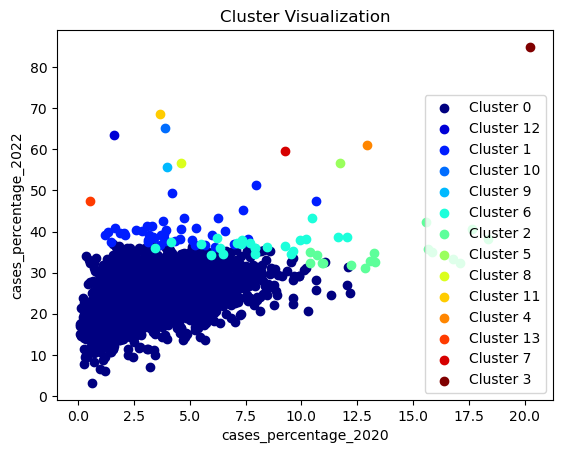

In [9]:
unique_labels = years['Cluster_Label'].unique()

# Define a colormap for plotting different clusters with different colors
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

# Create a scatter plot for each cluster
for label, color in zip(unique_labels, colors):
    cluster = years[years['Cluster_Label'] == label]
    plt.scatter(cluster['cases_percentage_2020'], cluster['cases_percentage_2022'], label=f'Cluster {label}', c=color)

plt.title('Cluster Visualization')
plt.xlabel('cases_percentage_2020')
plt.ylabel('cases_percentage_2022')
plt.legend()
plt.show()

As we can see, one cluster dominates most of the data, so we need to try another approach through demographics.

In [10]:
alldf = county_stats.drop(columns=['state', 'county','Less than a high school diploma', 'High school diploma only', 'Some college or associate\'s degree','Bachelor\'s degree or higher','pov_2021','cases_2022','cases_2021','cases_2020','pop_2020','pop_2021','pop_2022'])

In [11]:
alldf.head()

Percent of adults with less than a high school diploma  \
0                                                7.9        
1                                                4.3        
2                                                3.9        
3                                                2.3        
4                                                7.2        

   Percent of adults with a high school diploma only  \
0                                               29.5   
1                                               16.4   
2                                               21.3   
3                                               39.4   
4                                               29.4   

   Percent of adults completing some college or associate's degree  \
0                                               32.5                 
1                                               28.0                 
2                                               32.1                 
3                                               32.6                 
4                                               33.3                 

   Percent of adults with a bachelor's degree or higher  Percent Caucasian  \
0                                               30.1             37.887539   
1                                               51.3             86.171146   
2                                               42.7             86.756485   
3                                               25.6             77.172061   
4                                               30.2             39.363719   

   Percent African American  Percent Indian  Percent Asian  Percent Pacific  \
0                  1.104934        2.442072      35.683574        19.634968   
1                  0.938773        2.867901       2.475886         0.448754   
2                  1.330501        4.329718       2.683363         0.614937   
3                  0.681431       15.885860       2.044293         0.809199   
4                  1.394991        2.929201      28.874003        23.942913   

   avg_house_size  pop_density  cases_percentage_2022  cases_percentage_2021  \
0            3.13    44.458014              17.428533               0.439078   
1            2.03    36.571796               7.769800               0.993822   
2            2.11     6.605031               9.520974               1.236554   
3            2.41     0.415545              30.350195               1.350048   
4            2.84    18.944303              13.777476               1.456387   

   cases_percentage_2020  pov_percentage  
0               0.106578       10.978304  
1               0.246817       10.727908  
2               0.320600       11.021722  
3               0.767018       10.752170  
4               0.731894       14.407337

In [12]:
bandwidth = estimate_bandwidth(alldf)
#print(bandwidth)
mean_shift = MeanShift(bandwidth=bandwidth)
mean_shift.fit(alldf)
cluster_labels = mean_shift.labels_
num_clusters = len(set(cluster_labels))
alldf['Cluster_Label'] = cluster_labels
#print('Clusters: ' + str(len(set(cluster_labels))))

C:\Users\matth\AppData\Local\Temp\ipykernel_32712\3658117335.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster['cases_percentage_2020'], cluster['cases_percentage_2022'], label=f'Cluster {label}', c=color)


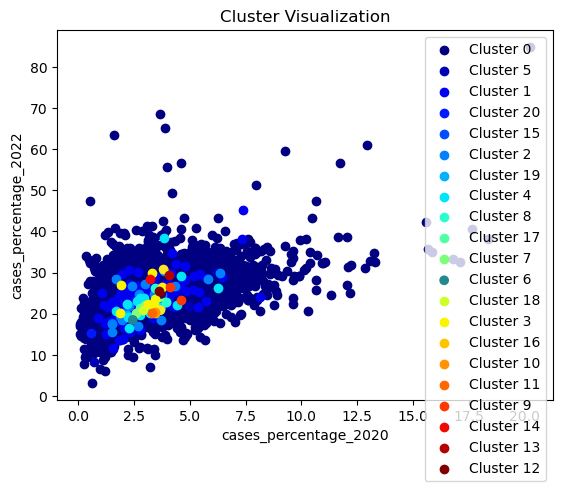

In [13]:
unique_labels = alldf['Cluster_Label'].unique()

# Define a colormap for plotting different clusters with different colors
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

# Create a scatter plot for each cluster
for label, color in zip(unique_labels, colors):
    cluster = alldf[alldf['Cluster_Label'] == label]
    plt.scatter(cluster['cases_percentage_2020'], cluster['cases_percentage_2022'], label=f'Cluster {label}', c=color)

plt.title('Cluster Visualization')
plt.xlabel('cases_percentage_2020')
plt.ylabel('cases_percentage_2022')
plt.legend()
plt.show()

We still have too many clusters, but let's try and find trends within each cluster that has a reasonable amount of data points.

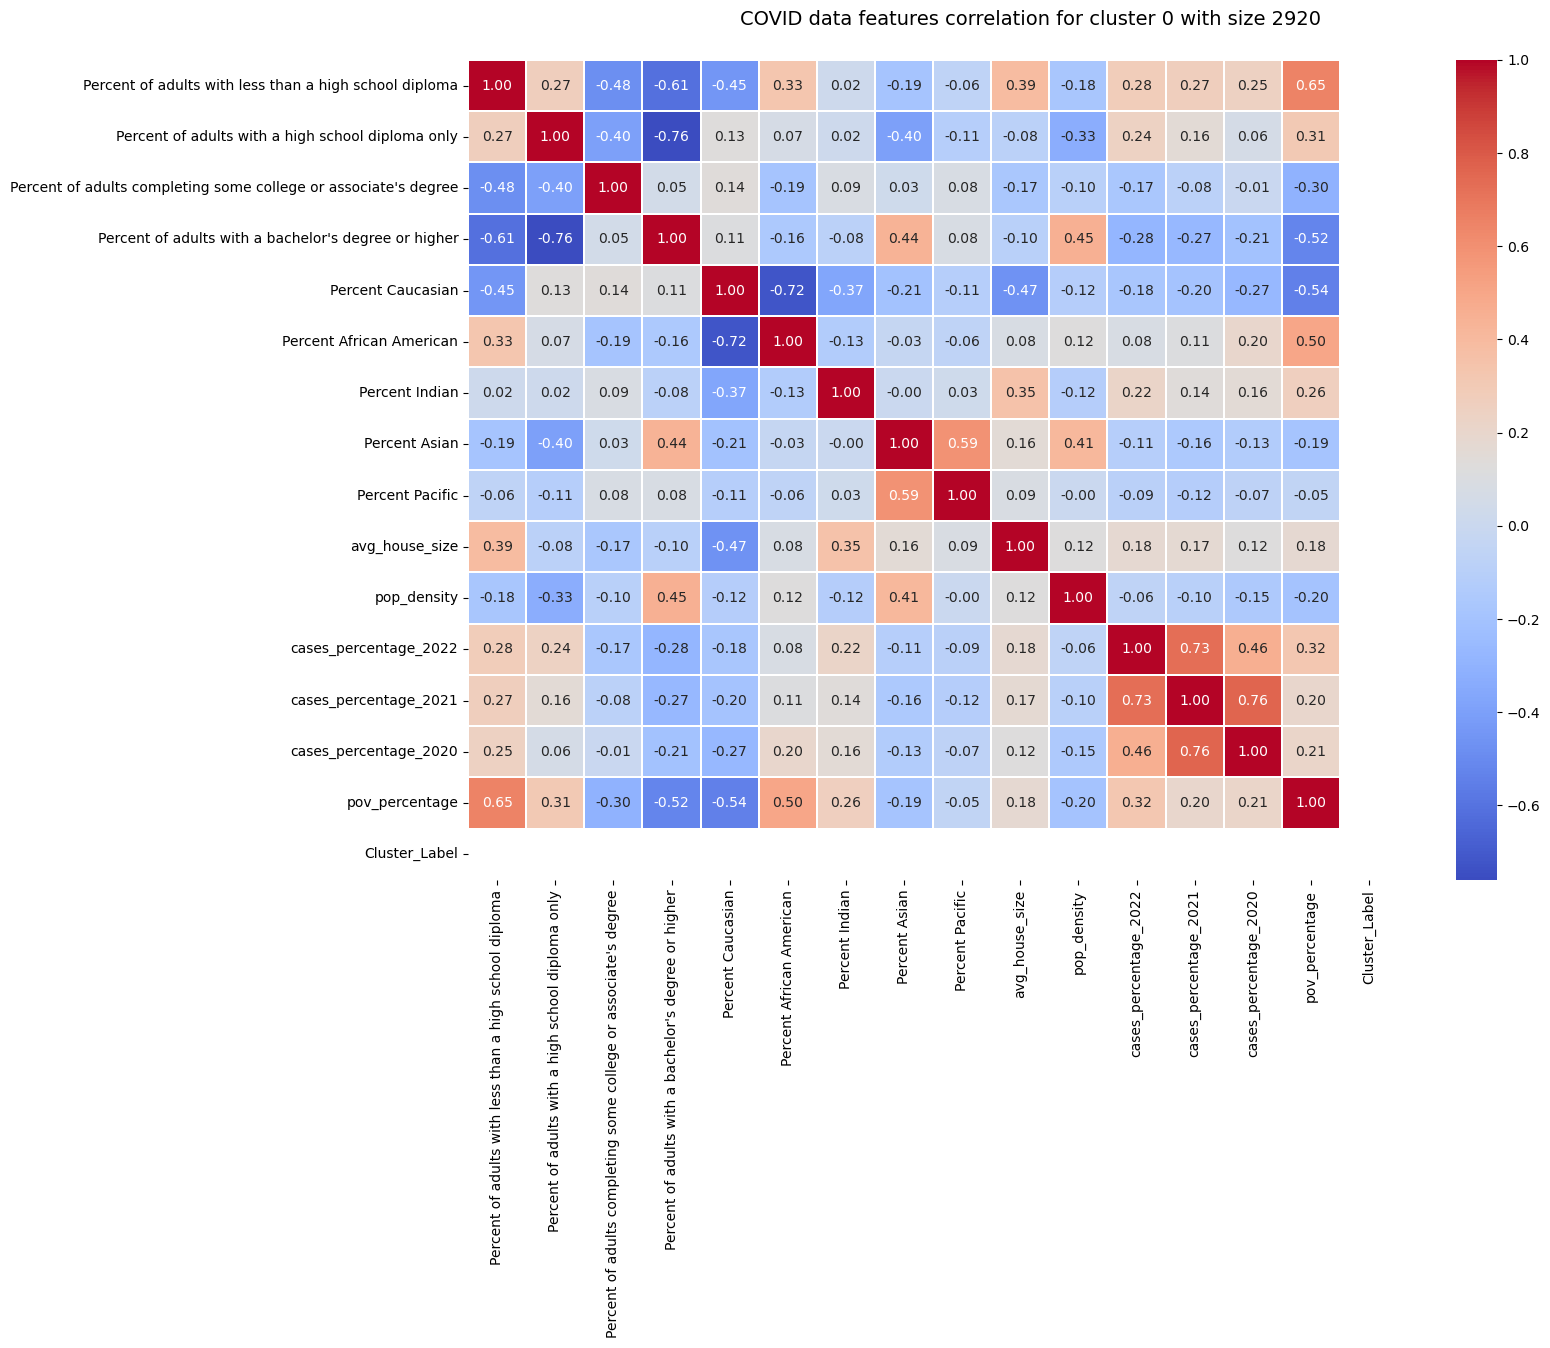

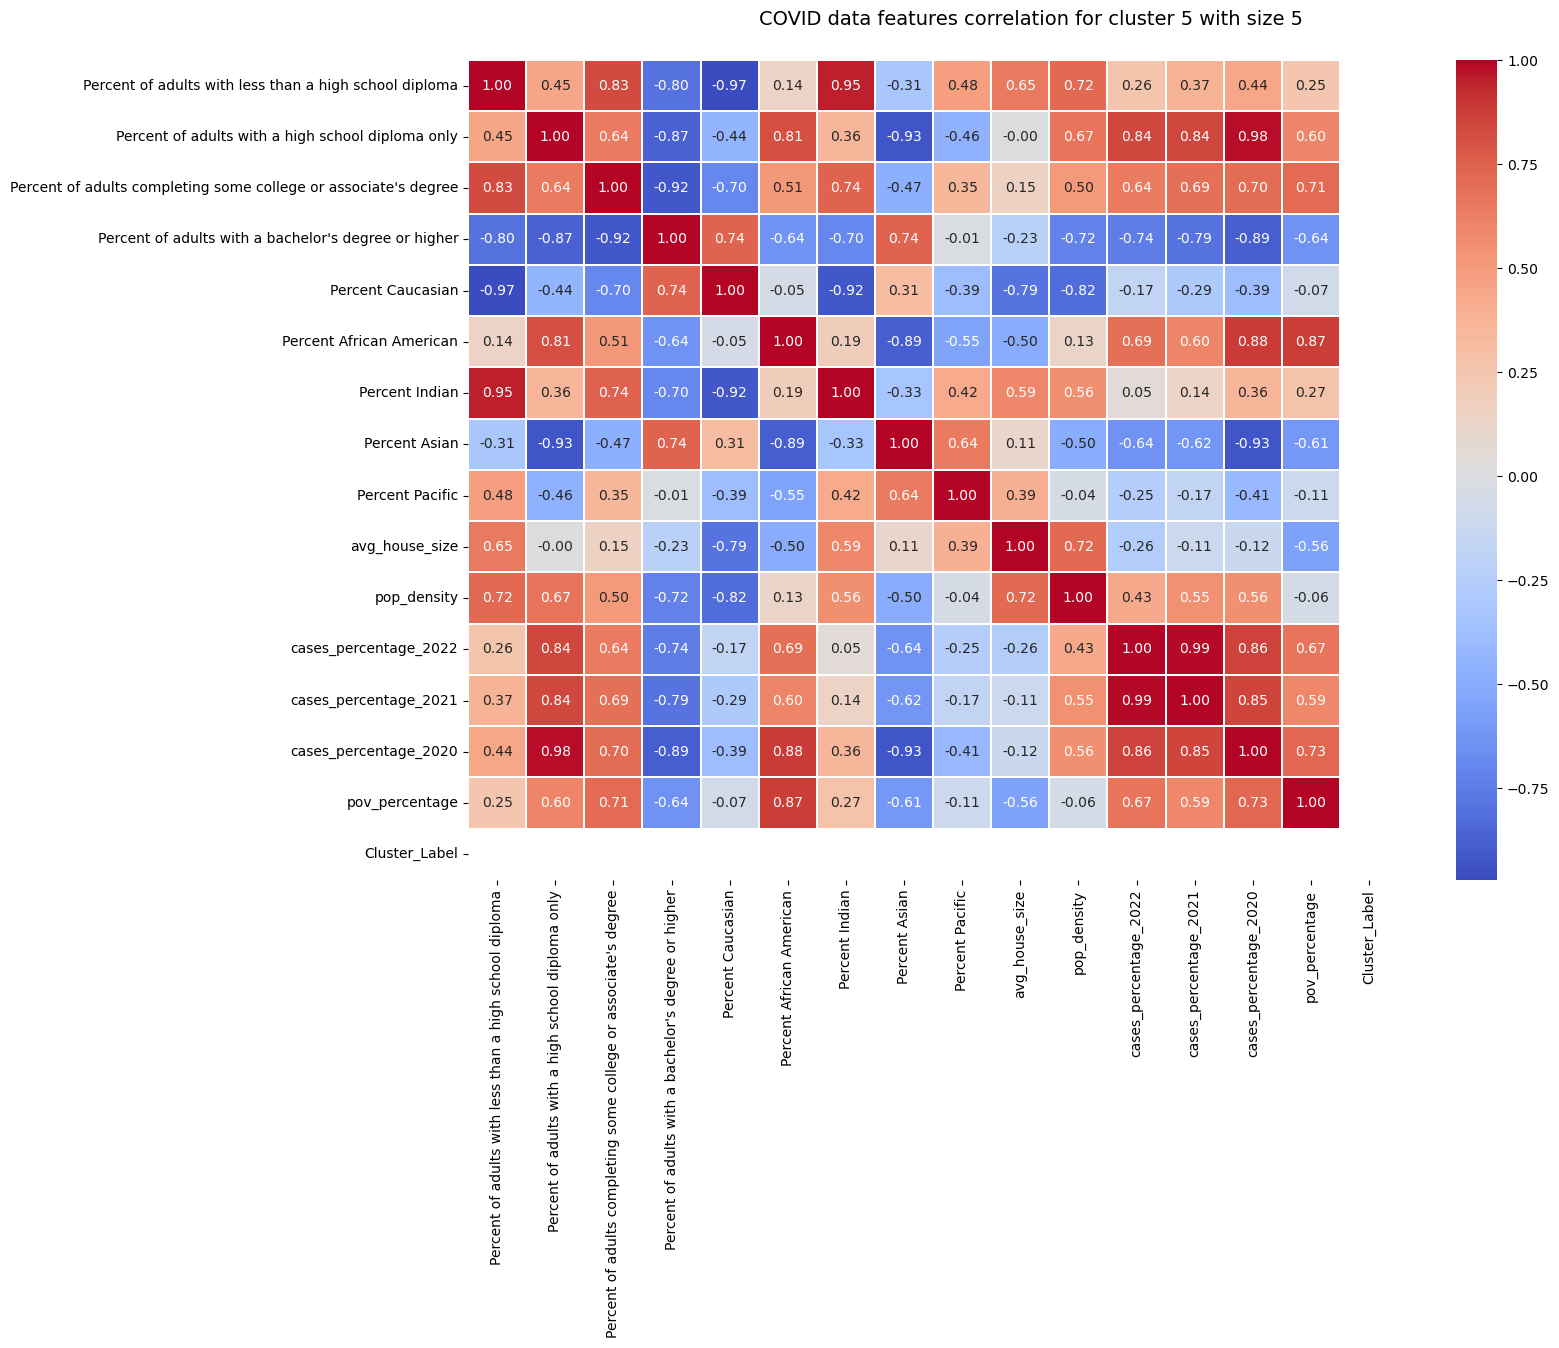

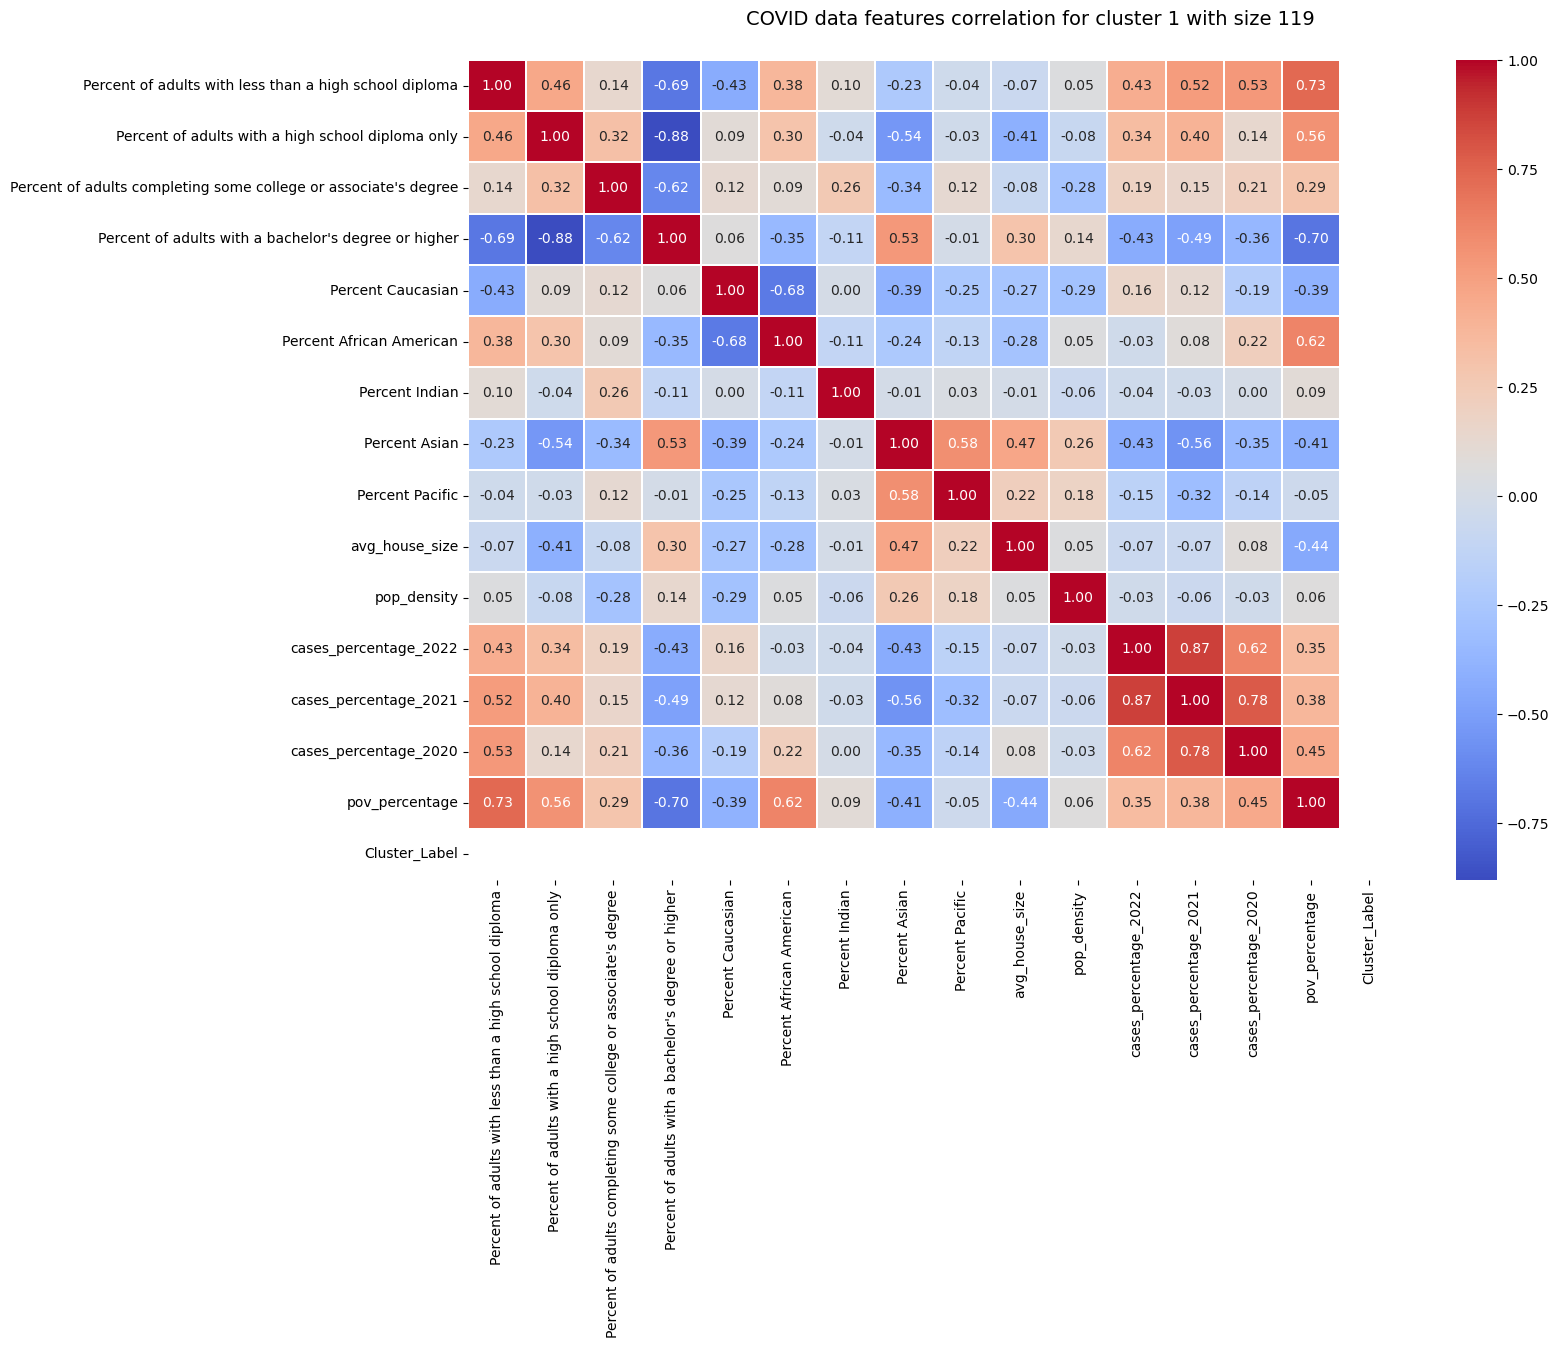

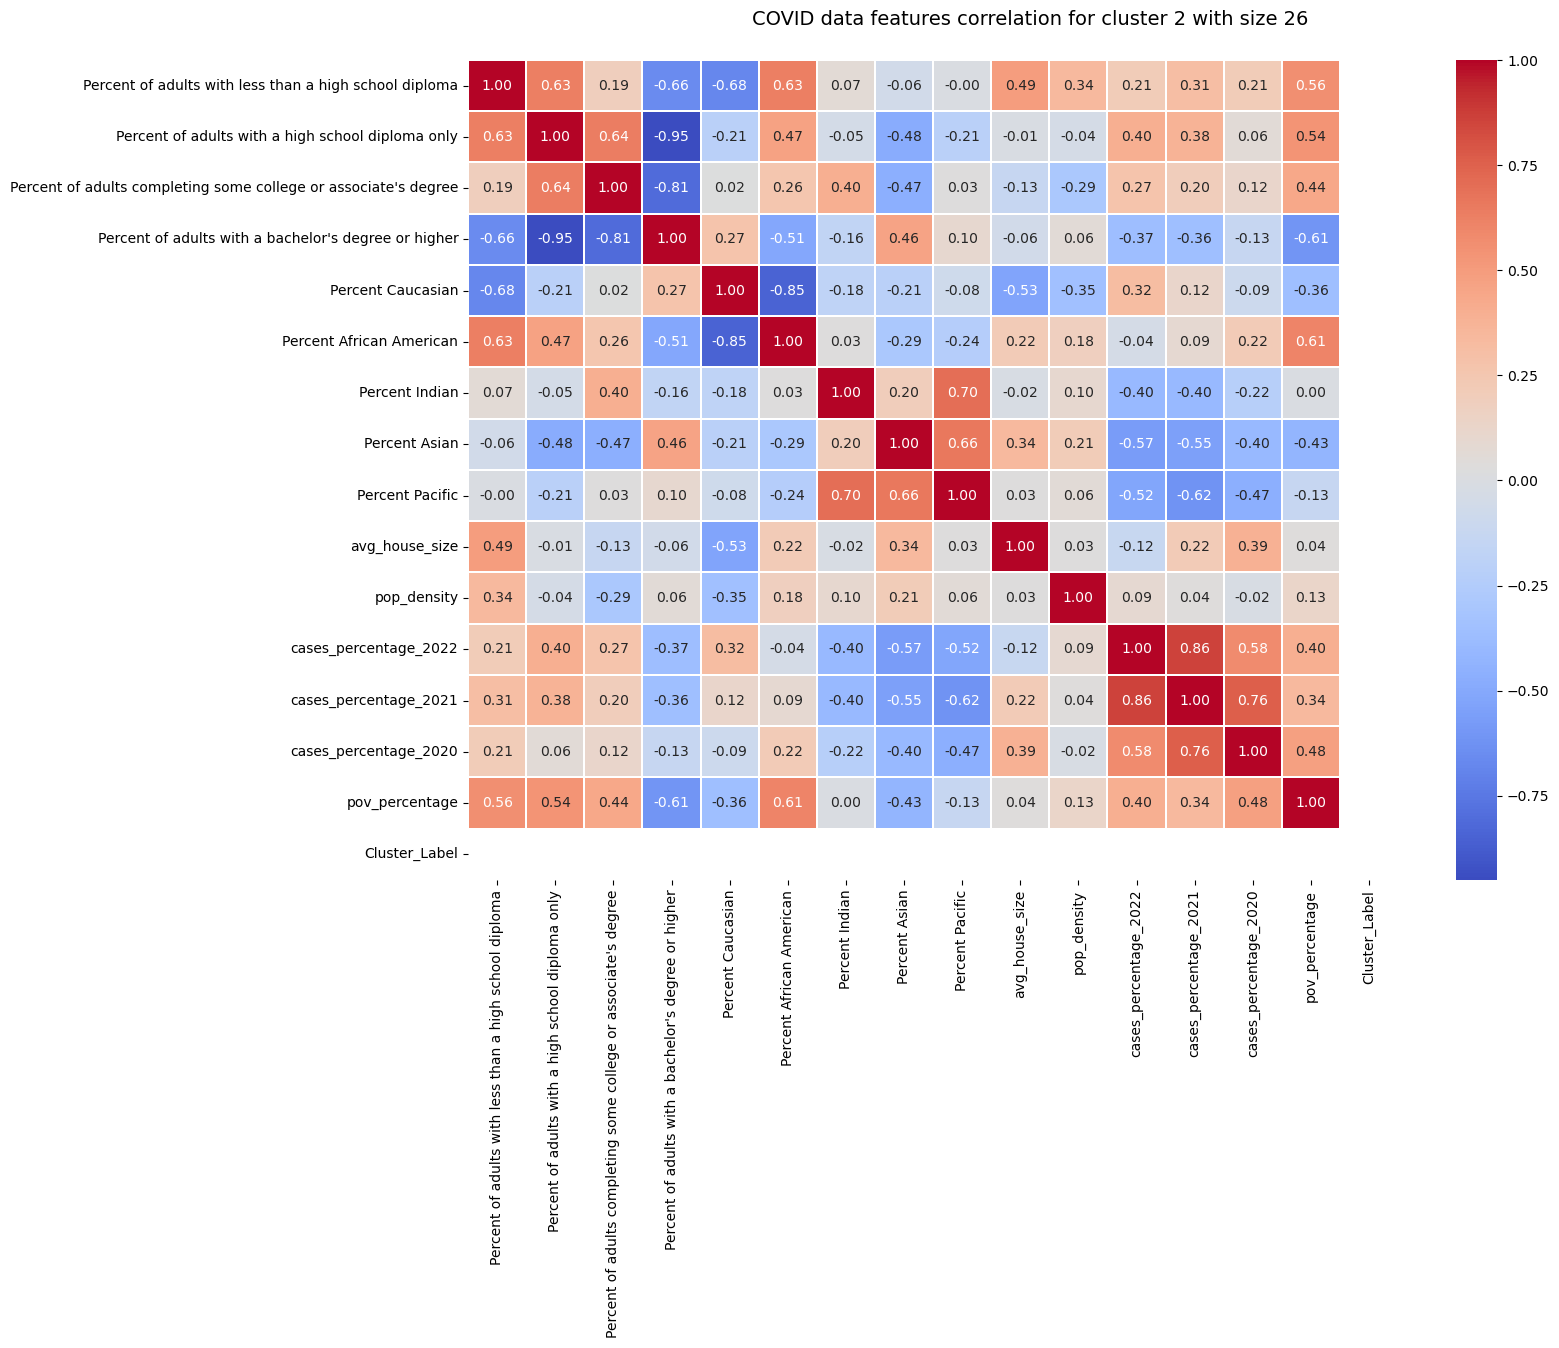

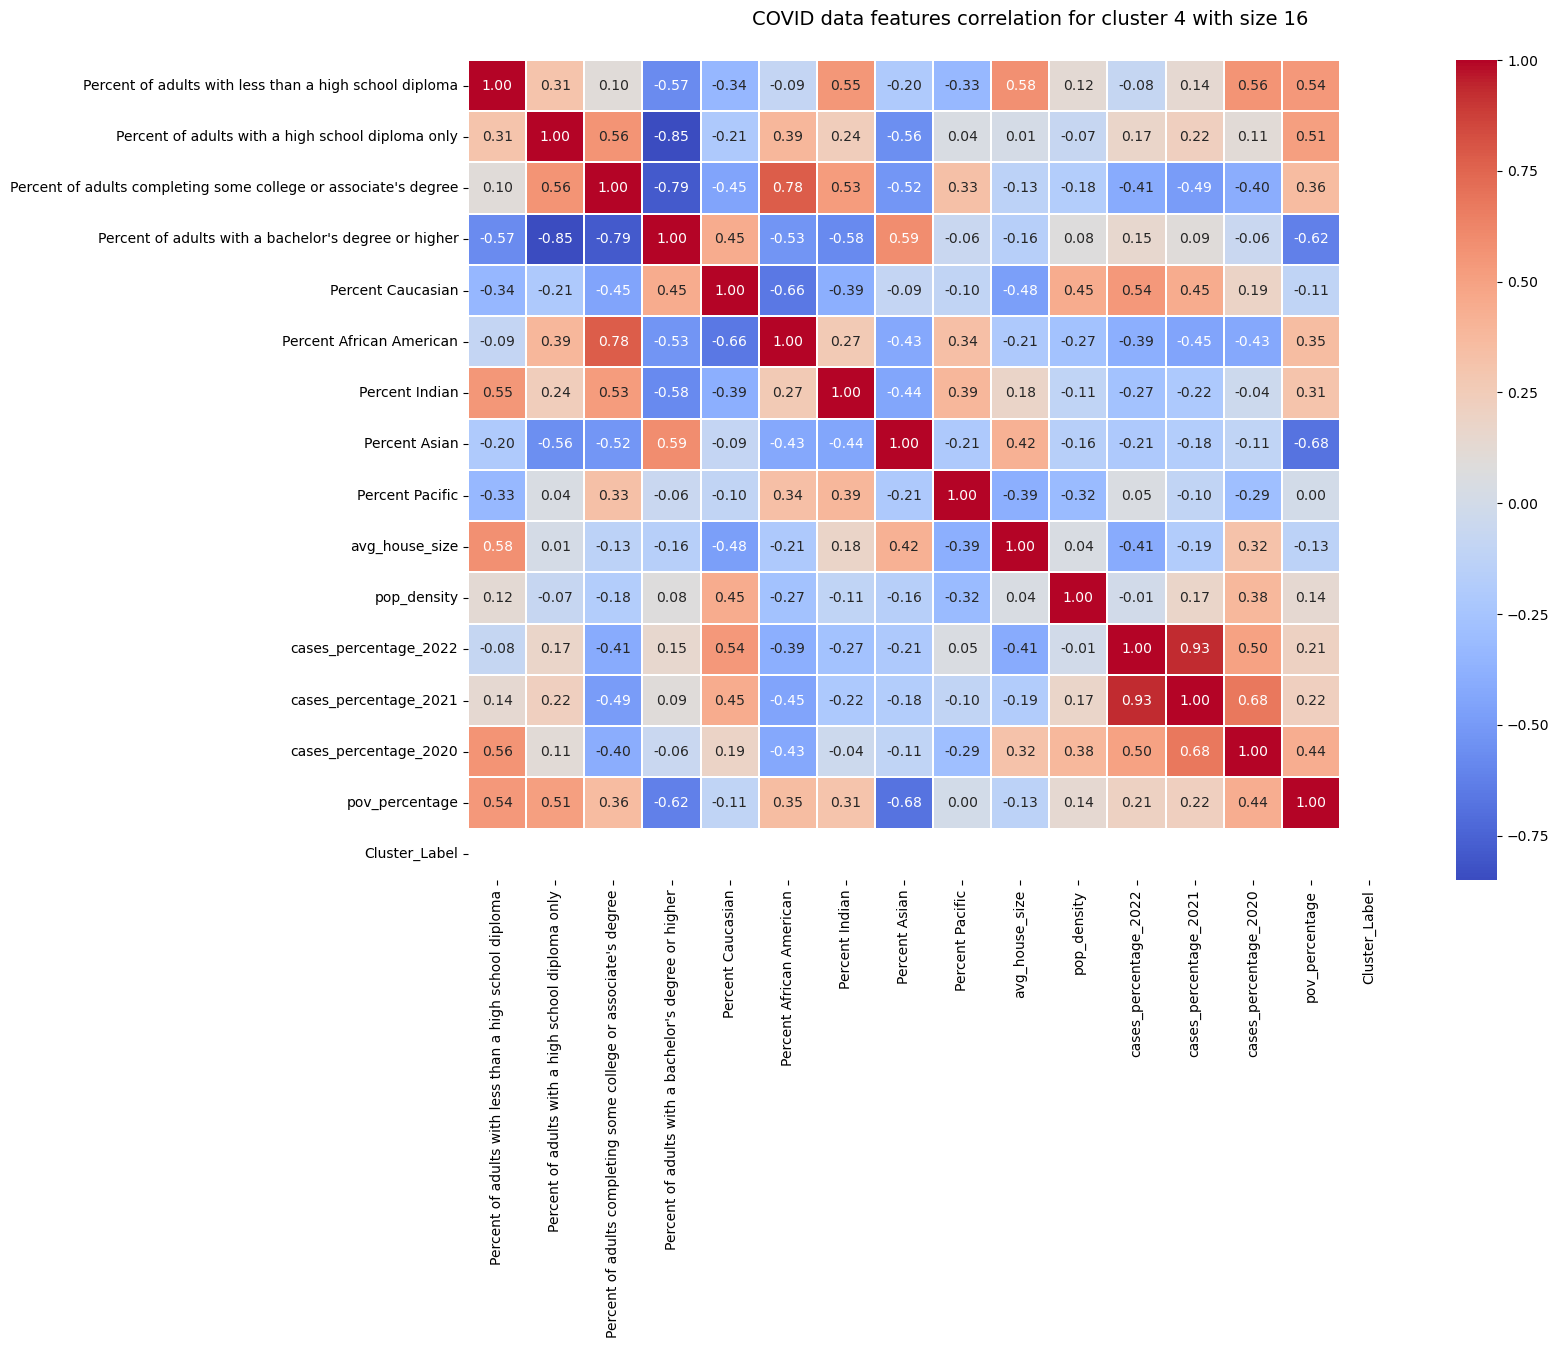

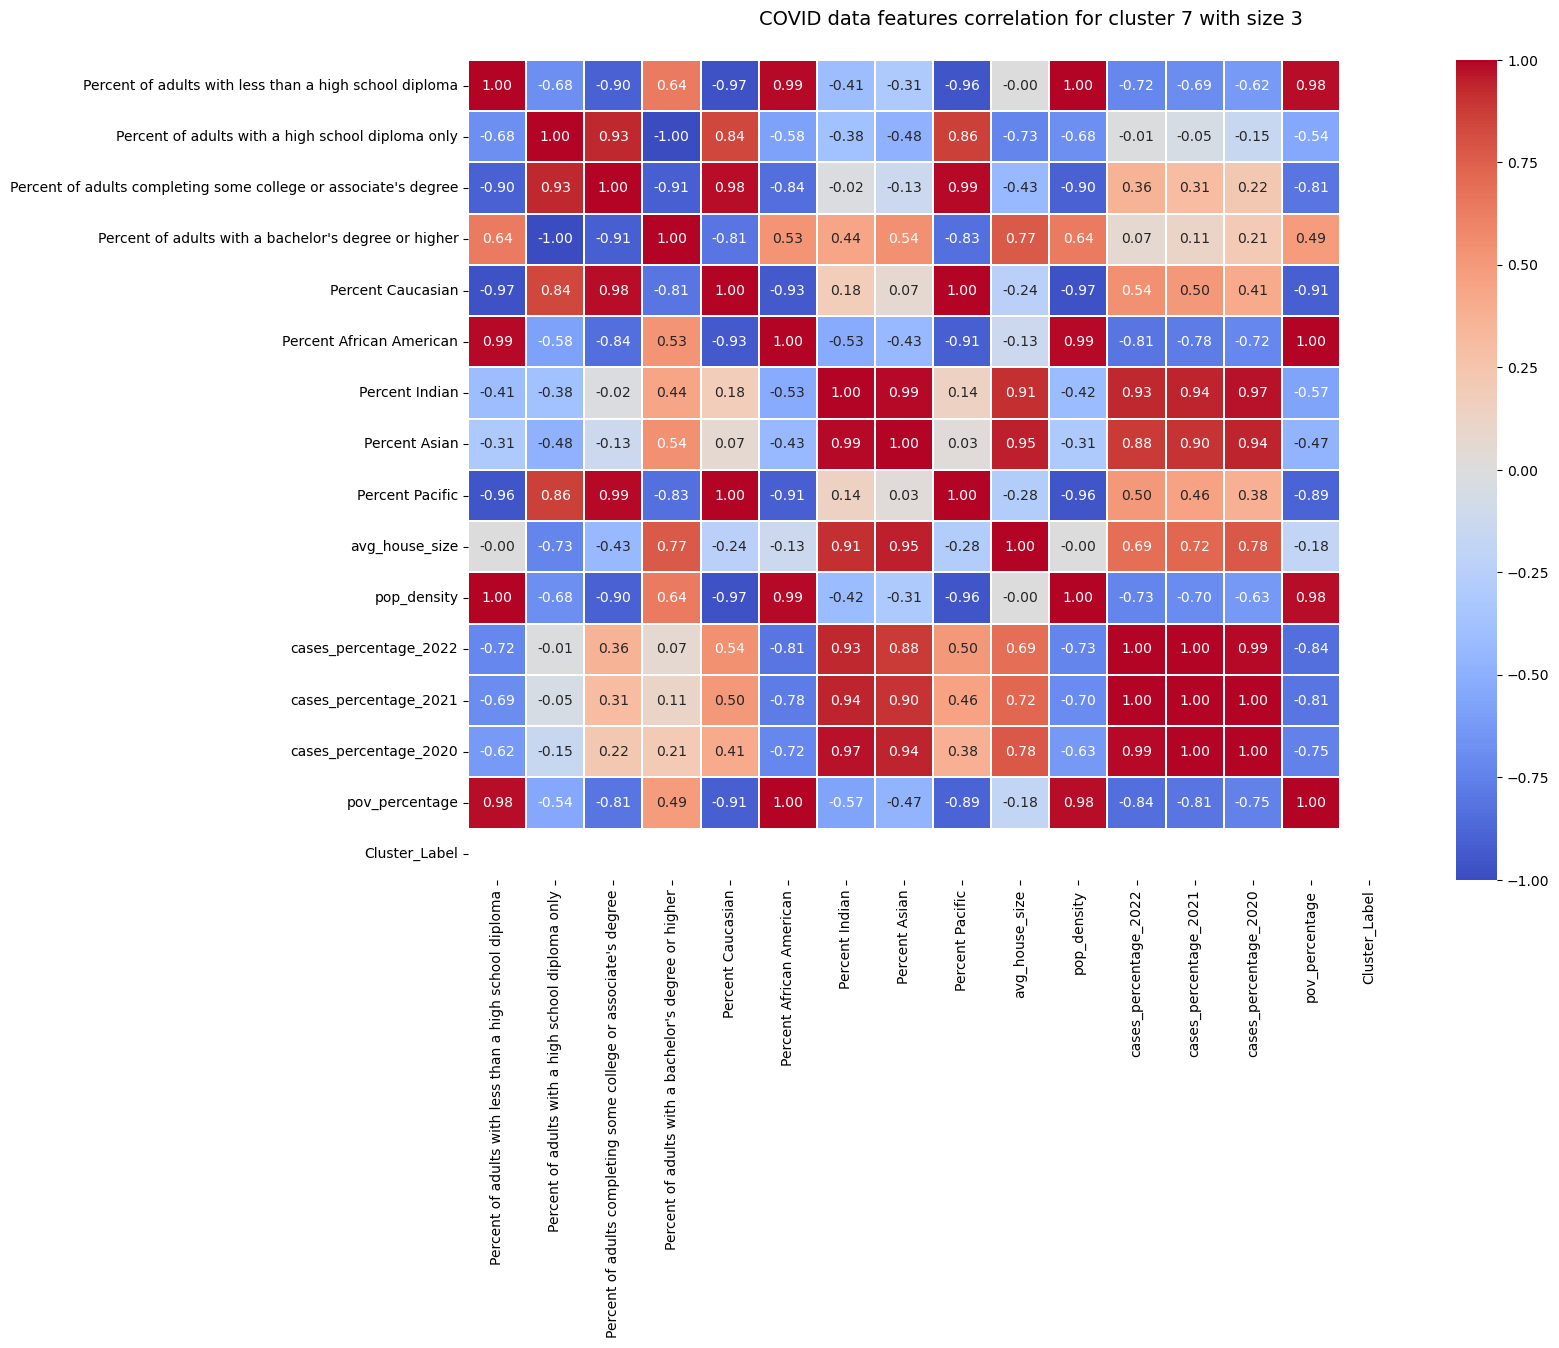

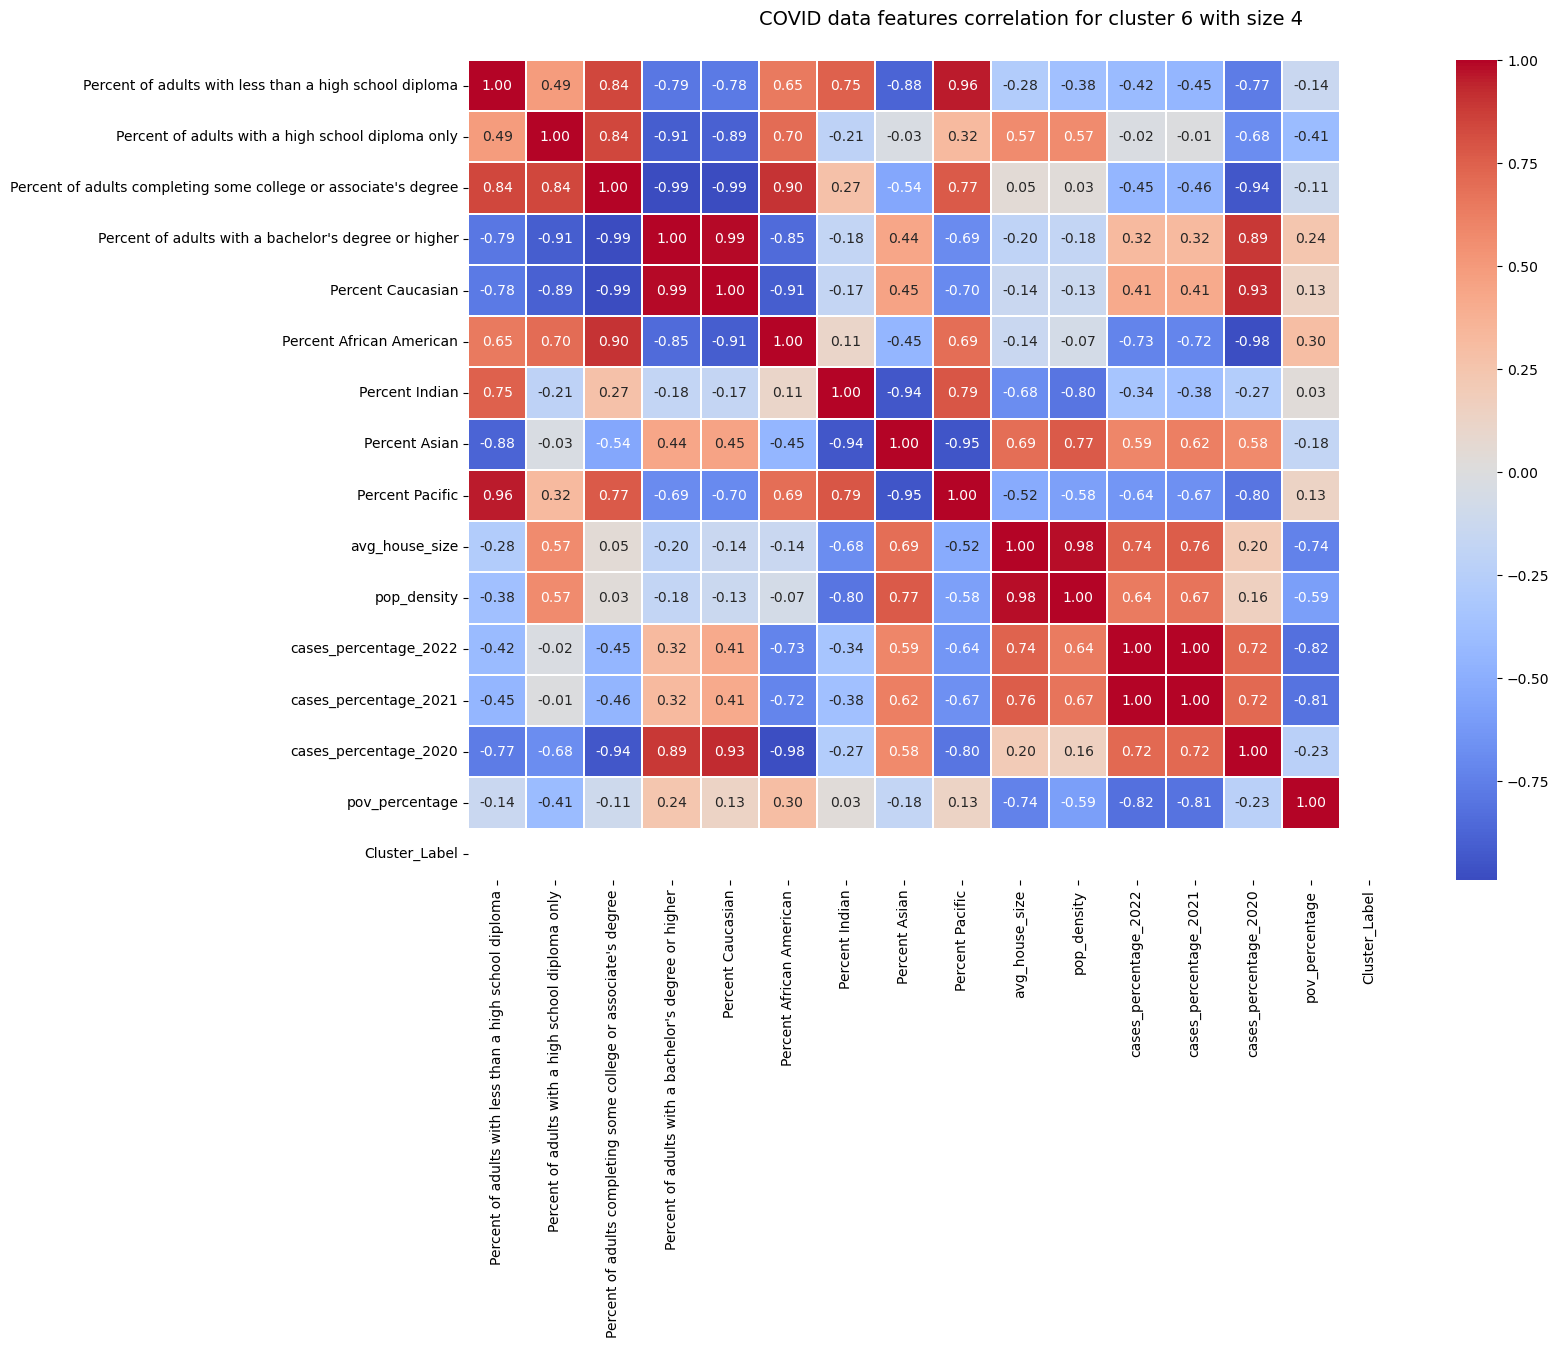

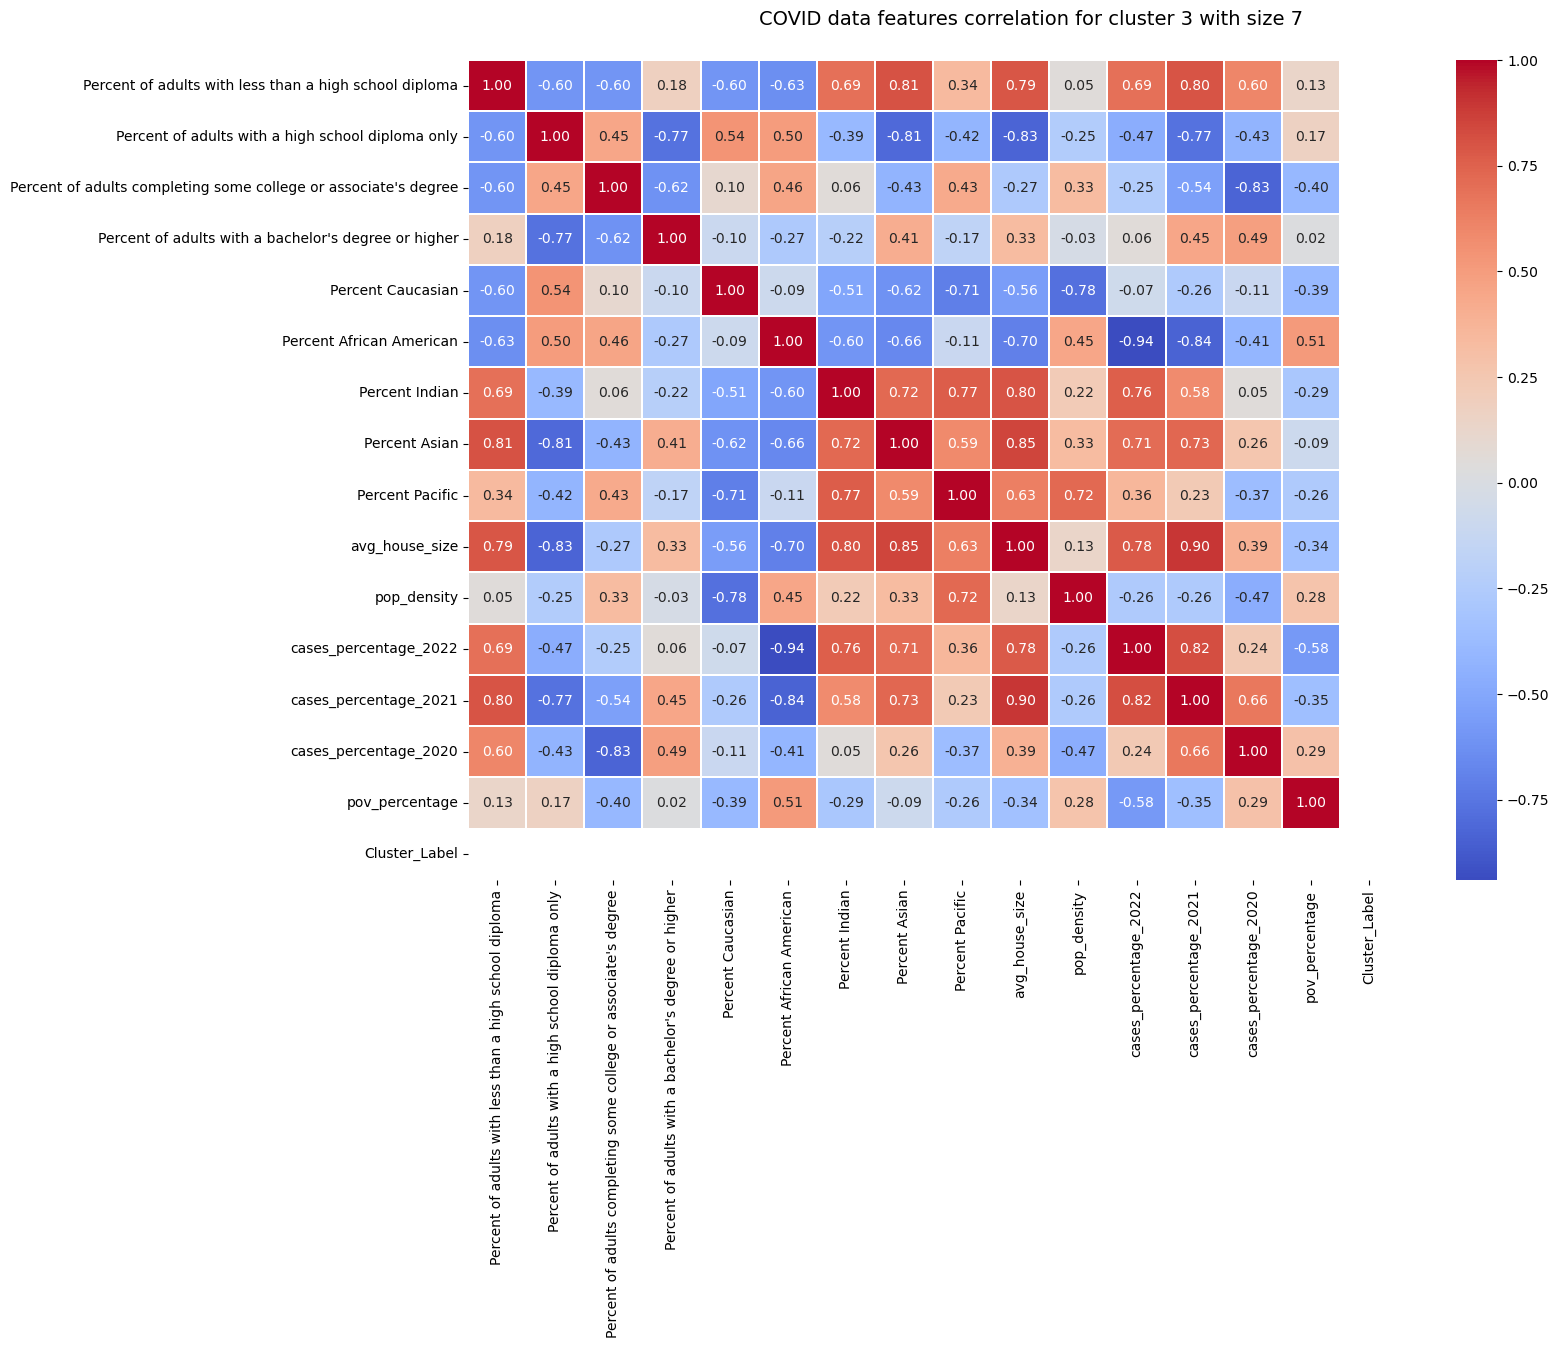

In [14]:
import warnings
warnings.filterwarnings('ignore')

for label in unique_labels:
    cluster = alldf[alldf['Cluster_Label'] == label]
    if len(cluster) <= 2:
        continue
    corrmat = cluster.corr(numeric_only=True)
    f, ax = plt.subplots(figsize=(15, 10))
    hm = sns.heatmap(round(corrmat,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
    f.subplots_adjust(top=0.93)
    t= f.suptitle('COVID data features correlation for cluster ' + str(label) + ' with size ' + str(len(cluster)), fontsize=14)

There aren't very noticiable trends for the clusters that have large amounts of data points (counties). We need to take another modeling approach.

# PCA

In [15]:
dfPCA = alldf.drop(columns=['Cluster_Label'])

dfPCA.head()

Percent of adults with less than a high school diploma  \
0                                                7.9        
1                                                4.3        
2                                                3.9        
3                                                2.3        
4                                                7.2        

   Percent of adults with a high school diploma only  \
0                                               29.5   
1                                               16.4   
2                                               21.3   
3                                               39.4   
4                                               29.4   

   Percent of adults completing some college or associate's degree  \
0                                               32.5                 
1                                               28.0                 
2                                               32.1                 
3                                               32.6                 
4                                               33.3                 

   Percent of adults with a bachelor's degree or higher  Percent Caucasian  \
0                                               30.1             37.887539   
1                                               51.3             86.171146   
2                                               42.7             86.756485   
3                                               25.6             77.172061   
4                                               30.2             39.363719   

   Percent African American  Percent Indian  Percent Asian  Percent Pacific  \
0                  1.104934        2.442072      35.683574        19.634968   
1                  0.938773        2.867901       2.475886         0.448754   
2                  1.330501        4.329718       2.683363         0.614937   
3                  0.681431       15.885860       2.044293         0.809199   
4                  1.394991        2.929201      28.874003        23.942913   

   avg_house_size  pop_density  cases_percentage_2022  cases_percentage_2021  \
0            3.13    44.458014              17.428533               0.439078   
1            2.03    36.571796               7.769800               0.993822   
2            2.11     6.605031               9.520974               1.236554   
3            2.41     0.415545              30.350195               1.350048   
4            2.84    18.944303              13.777476               1.456387   

   cases_percentage_2020  pov_percentage  
0               0.106578       10.978304  
1               0.246817       10.727908  
2               0.320600       11.021722  
3               0.767018       10.752170  
4               0.731894       14.407337

In [16]:
# SCALE data
PCAcolumns = dfPCA.columns
scalePCA = scale(dfPCA)

df_scale = pd.DataFrame(scalePCA, columns=PCAcolumns)
df_scale.head()

Percent of adults with less than a high school diploma  \
0                                          -0.707456        
1                                          -1.323386        
2                                          -1.391822        
3                                          -1.665569        
4                                          -0.827220        

   Percent of adults with a high school diploma only  \
0                                          -0.597062   
1                                          -2.345078   
2                                          -1.691240   
3                                           0.723958   
4                                          -0.610406   

   Percent of adults completing some college or associate's degree  \
0                                           0.291196                 
1                                          -0.565506                 
2                                           0.215045                 
3                                           0.310234                 
4                                           0.443499                 

   Percent of adults with a bachelor's degree or higher  Percent Caucasian  \
0                                           0.714203             -2.420637   
1                                           2.852449              0.496776   
2                                           1.985047              0.532143   
3                                           0.260331             -0.046971   
4                                           0.724289             -2.331442   

   Percent African American  Percent Indian  Percent Asian  Percent Pacific  \
0                 -0.594599       -0.179770      11.510289        24.160078   
1                 -0.606565       -0.125038       0.216934         0.234754   
2                 -0.578355        0.062850       0.287493         0.441985   
3                 -0.625097        1.548160       0.070157         0.684231   
4                 -0.573710       -0.117159       9.194473        29.532111   

   avg_house_size  pop_density  cases_percentage_2022  cases_percentage_2021  \
0        2.241223    -0.116388              -1.306523              -3.187091   
1       -1.791815    -0.137732              -2.995211              -3.006598   
2       -1.498503    -0.218836              -2.689044              -2.927622   
3       -0.398584    -0.235587               0.952641              -2.890696   
4        1.177967    -0.185440              -1.944857              -2.856097   

   cases_percentage_2020  pov_percentage  
0              -1.694429       -0.590967  
1              -1.626110       -0.638365  
2              -1.590165       -0.582749  
3              -1.372687       -0.633772  
4              -1.389798        0.058112

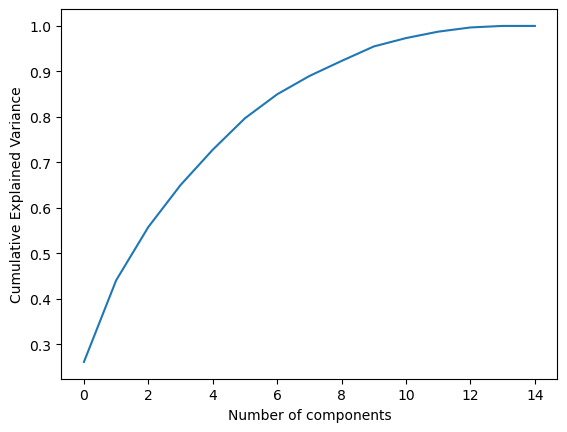

In [17]:
#Apply PCA to the scaled data
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df_scale)
features = range(pca.n_components_)

#Plot the number of components versus the cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

5 components accounts for about 80% of the variance and 9 components gets us just above 90%

 ### Cluster Models

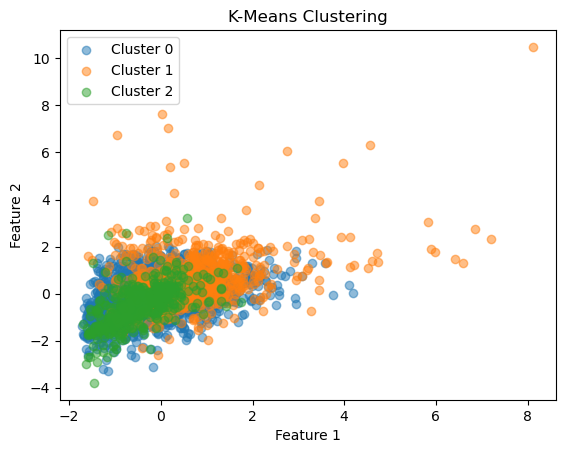

In [18]:
from sklearn.cluster import KMeans

# Create a KMeans instance
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model to your data
kmeans.fit(df_scale)

# Get cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to your DataFrame
df_scale['Cluster'] = labels

# plot df_scale using covid cases

for cluster in range(3):
    cluster_data = df_scale[df_scale['Cluster'] == cluster]
    plt.scatter(cluster_data.iloc[:, 13], cluster_data.iloc[:, 11], label=f'Cluster {cluster}', alpha=0.5)

plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

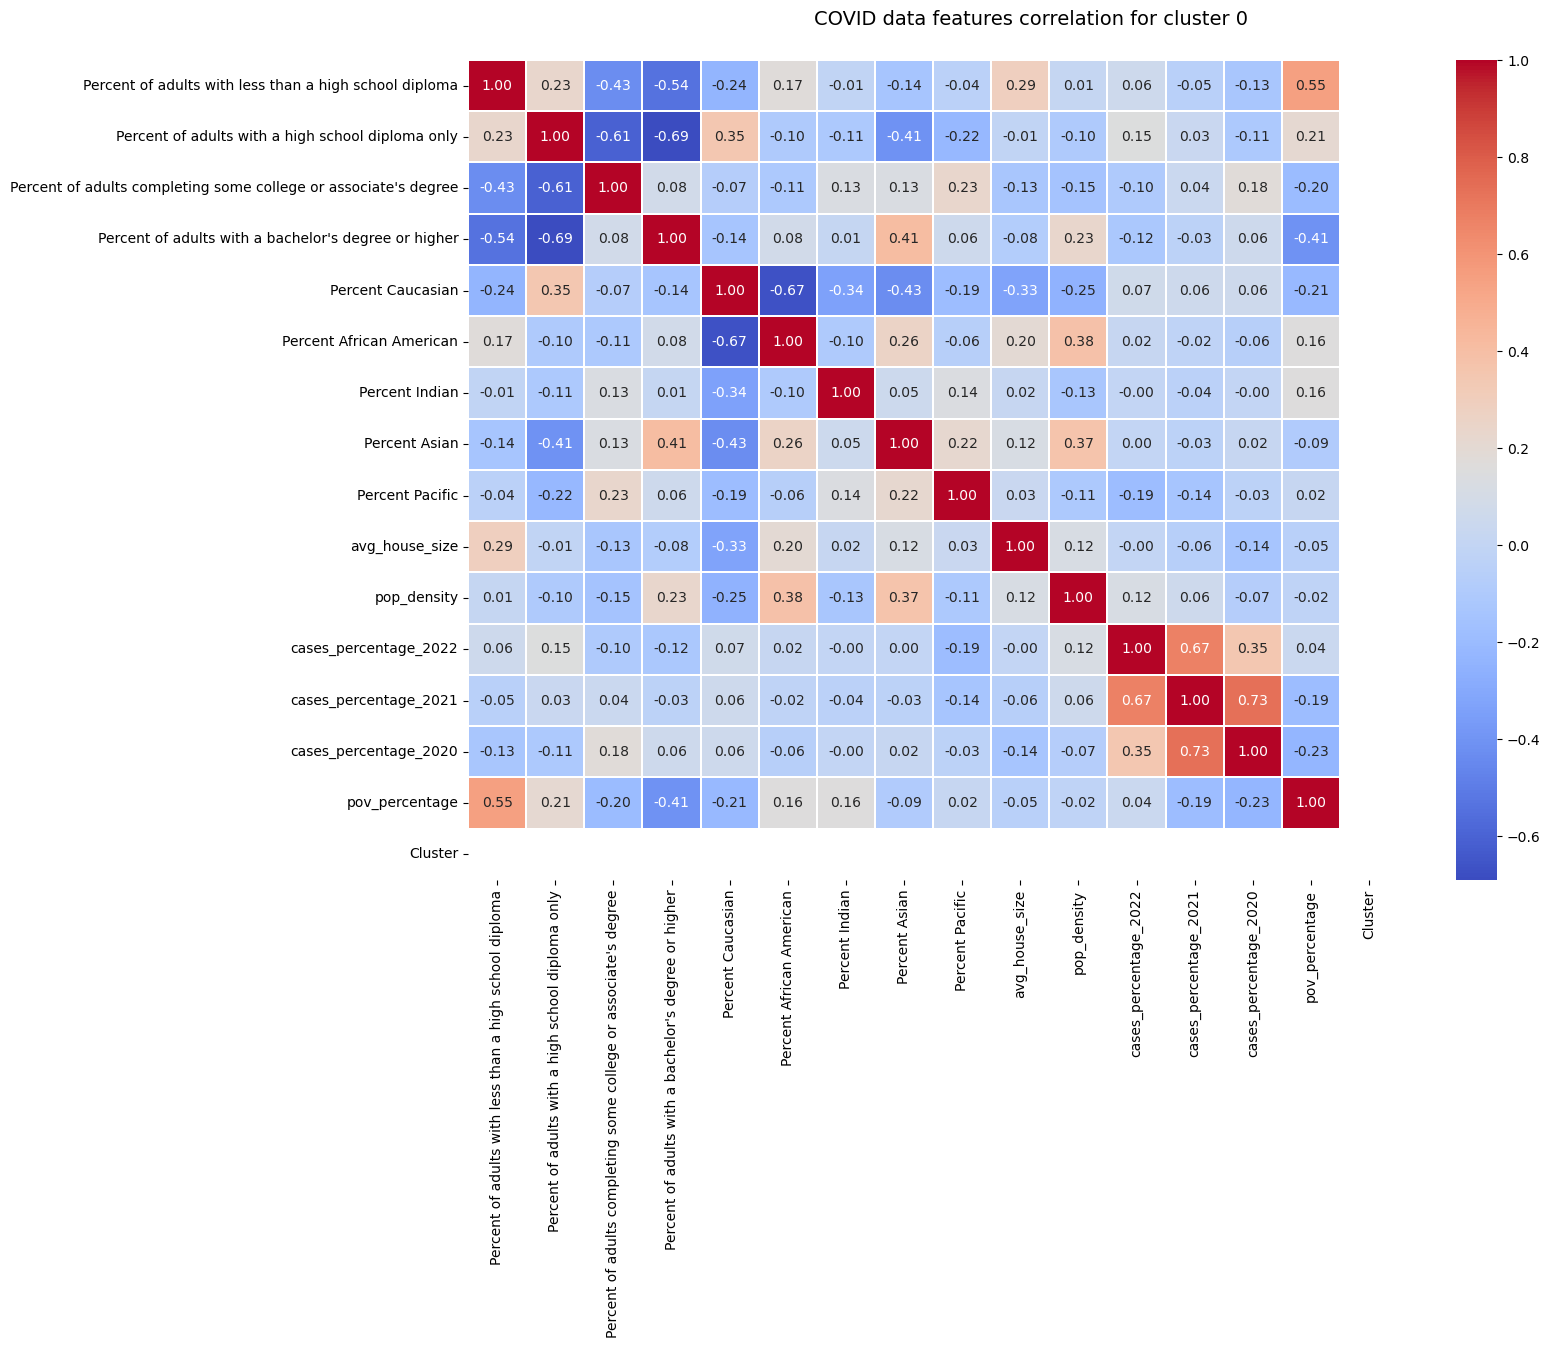

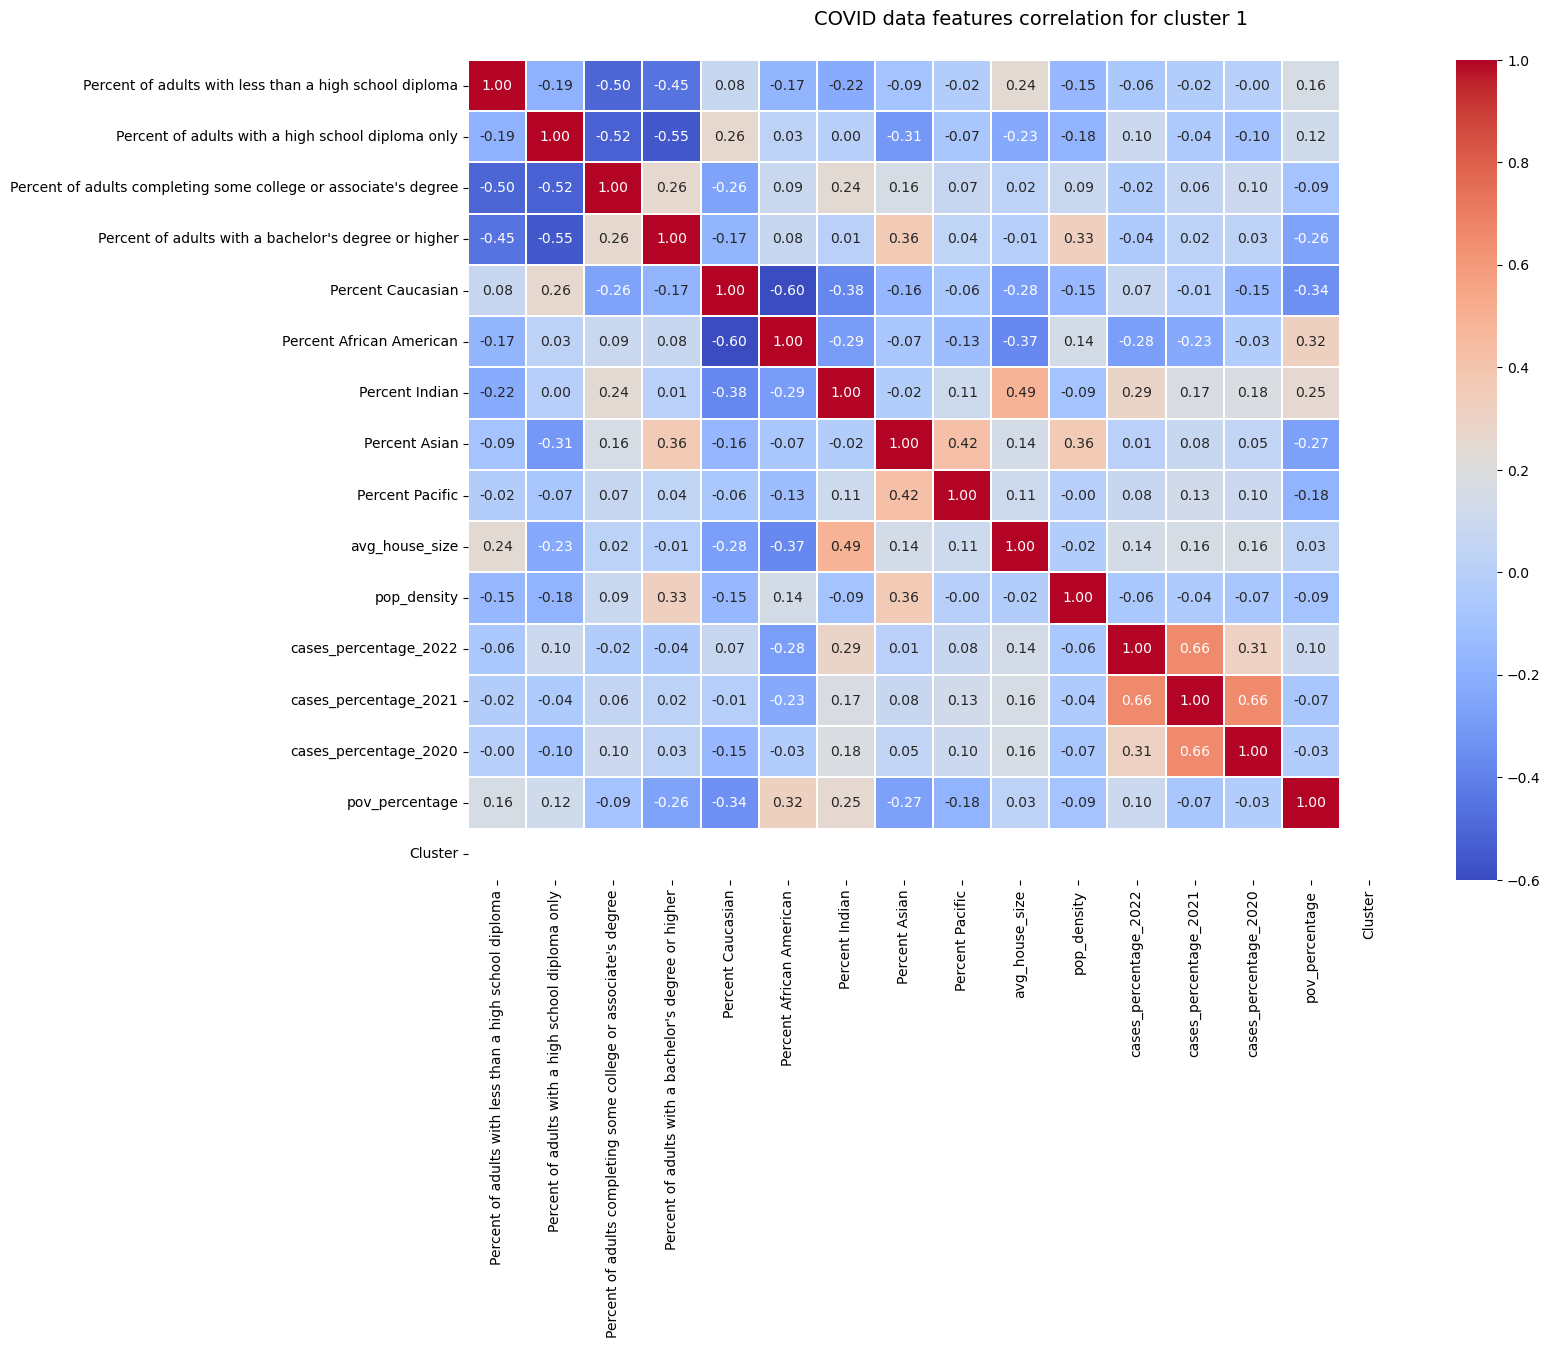

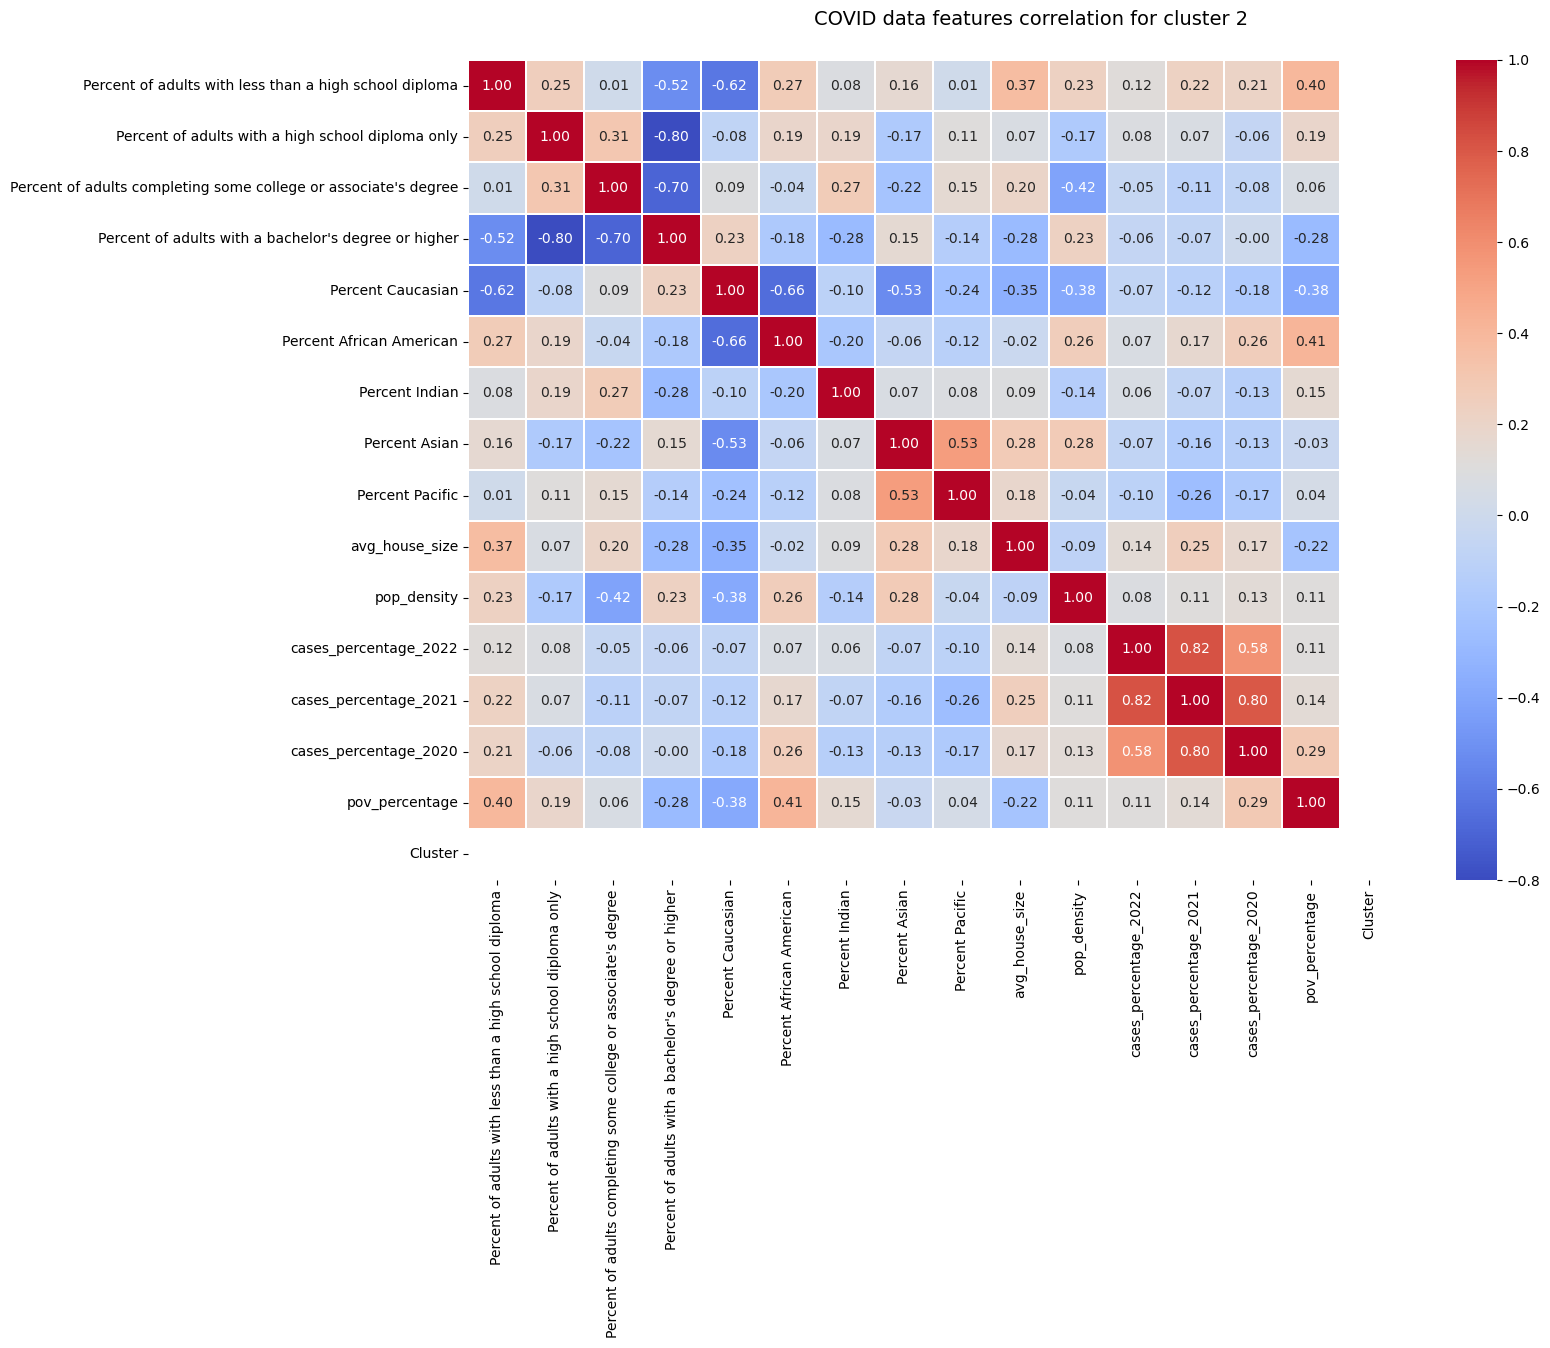

In [19]:
# plot heatmaps
for label in range(3):
    cluster = df_scale[df_scale['Cluster'] == label]#.drop('Cluster', axis=1)
    
    corrmat = cluster.corr(numeric_only=True)
    f, ax = plt.subplots(figsize=(15, 10))
    hm = sns.heatmap(round(corrmat,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
    f.subplots_adjust(top=0.93)
    t= f.suptitle('COVID data features correlation for cluster ' + str(label), fontsize=14) 

These heat maps weren't the best so we can try and cluster on only demographics.

In [20]:
df_demo_drop = ['cases_percentage_2022', 'cases_percentage_2021', 'cases_percentage_2020']
df_demo = df_scale.drop(columns=['cases_percentage_2022', 'cases_percentage_2021', 'cases_percentage_2020', 'Cluster'])
df_demo.head()

Percent of adults with less than a high school diploma  \
0                                          -0.707456        
1                                          -1.323386        
2                                          -1.391822        
3                                          -1.665569        
4                                          -0.827220        

   Percent of adults with a high school diploma only  \
0                                          -0.597062   
1                                          -2.345078   
2                                          -1.691240   
3                                           0.723958   
4                                          -0.610406   

   Percent of adults completing some college or associate's degree  \
0                                           0.291196                 
1                                          -0.565506                 
2                                           0.215045                 
3                                           0.310234                 
4                                           0.443499                 

   Percent of adults with a bachelor's degree or higher  Percent Caucasian  \
0                                           0.714203             -2.420637   
1                                           2.852449              0.496776   
2                                           1.985047              0.532143   
3                                           0.260331             -0.046971   
4                                           0.724289             -2.331442   

   Percent African American  Percent Indian  Percent Asian  Percent Pacific  \
0                 -0.594599       -0.179770      11.510289        24.160078   
1                 -0.606565       -0.125038       0.216934         0.234754   
2                 -0.578355        0.062850       0.287493         0.441985   
3                 -0.625097        1.548160       0.070157         0.684231   
4                 -0.573710       -0.117159       9.194473        29.532111   

   avg_house_size  pop_density  pov_percentage  
0        2.241223    -0.116388       -0.590967  
1       -1.791815    -0.137732       -0.638365  
2       -1.498503    -0.218836       -0.582749  
3       -0.398584    -0.235587       -0.633772  
4        1.177967    -0.185440        0.058112

In [21]:
# Calculate wccs to figure out how many clusters
wccs = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_demo)
    wccs.append(kmeans.inertia_)

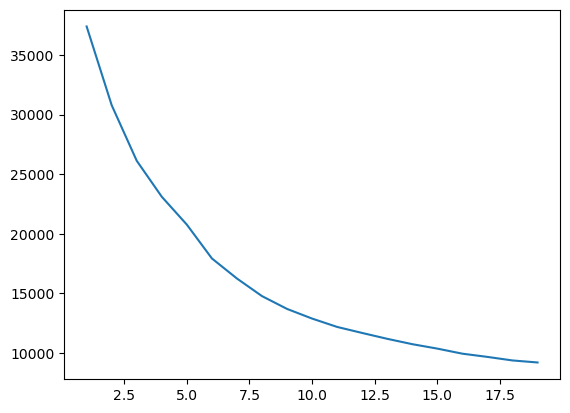

In [22]:
plt.plot(range(1, 20), wccs)

We can choose 10 clusters to get the best results.

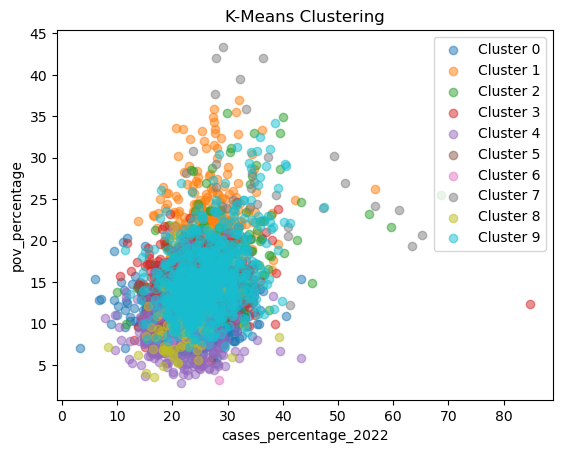

In [23]:
# Create a KMeans instance
kmeans = KMeans(n_clusters=10, random_state=42)

# Fit the model to your data
kmeans.fit(df_demo)

# Get cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to your DataFrame
df_demo['Cluster'] = labels

# plot df_scale using covid cases

df_demo = pd.concat([county_stats, df_demo['Cluster']], axis=1)

for cluster in range(10):
    cluster_data = df_demo[df_demo['Cluster'] == cluster]
    plt.scatter(cluster_data.iloc[:, 22], cluster_data.iloc[:, 27], label=f'Cluster {cluster}', alpha=0.5)

plt.title('K-Means Clustering')
plt.xlabel('cases_percentage_2022')
plt.ylabel('pov_percentage')
plt.legend()
plt.show()

In [24]:
for label in range(10):
    print('Cluster ' + str(label) + ' has size ' + str(len(df_demo[df_demo['Cluster'] == label])))  

Cluster 0 has size 828
Cluster 1 has size 315
Cluster 2 has size 162
Cluster 3 has size 499
Cluster 4 has size 439
Cluster 5 has size 4
Cluster 6 has size 8
Cluster 7 has size 37
Cluster 8 has size 87
Cluster 9 has size 736


We can group the clusters to get better statistics and compare groups.

In [25]:
df_demo_mean = df_demo.drop(columns=['state','county'], axis=1).groupby('Cluster').mean()
df_demo_mean

pop_2020      pop_2021      pop_2022  \
Cluster                                             
0        3.022562e+04  3.035827e+04  3.046364e+04   
1        5.183348e+04  5.151337e+04  5.125020e+04   
2        1.112943e+05  1.115706e+05  1.118981e+05   
3        8.507401e+04  8.599786e+04  8.708588e+04   
4        2.363319e+05  2.379393e+05  2.396440e+05   
5        3.627408e+05  3.617682e+05  3.600285e+05   
6        1.728483e+06  1.675128e+06  1.675308e+06   
7        2.158281e+04  2.152973e+04  2.145478e+04   
8        9.994053e+05  9.955905e+05  9.962696e+05   
9        2.988668e+04  2.991095e+04  2.992024e+04   

         Less than a high school diploma  High school diploma only  \
Cluster                                                              
0                            1701.210145               6993.905797   
1                            4907.574603              11297.692063   
2                           15534.469136              19452.296296   
3                            6797.949900              17567.959920   
4                           12889.043280              39345.232346   
5                           18616.250000              68479.000000   
6                           70972.250000             114558.250000   
7                            2251.270270               4545.783784   
8                           78702.597701             136310.034483   
9                            2705.771739               8681.504076   

         Some college or associate's degree  Bachelor's degree or higher  \
Cluster                                                                    
0                               7452.643720                  5181.659420   
1                              10439.914286                  8304.479365   
2                              20469.290123                 15365.697531   
3                              18833.891784                 13837.933868   
4                              46873.599089                 60647.922551   
5                              80398.250000                 87600.250000   
6                             106112.125000                322132.750000   
7                               4664.675676                  2131.297297   
8                             172782.126437                290017.172414   
9                               5803.702446                  3836.241848   

         Percent of adults with less than a high school diploma  \
Cluster                                                           
0                                                 7.863647        
1                                                17.673651        
2                                                25.265432        
3                                                12.748297        
4                                                 7.105467        
5                                                 7.450000        
6                                                10.275000        
7                                                14.624324        
8                                                 9.729885        
9                                                14.045245        

         Percent of adults with a high school diploma only  \
Cluster                                                      
0                                                33.468720   
1                                                37.135873   
2                                                32.522222   
3                                                32.118838   
4                                                24.836674   
5                                                28.650000   
6                                                16.612500   
7                                                36.270270   
8                                                20.654023   
9                                                41.895516   

         Percent of adults completing some college or associate's degree

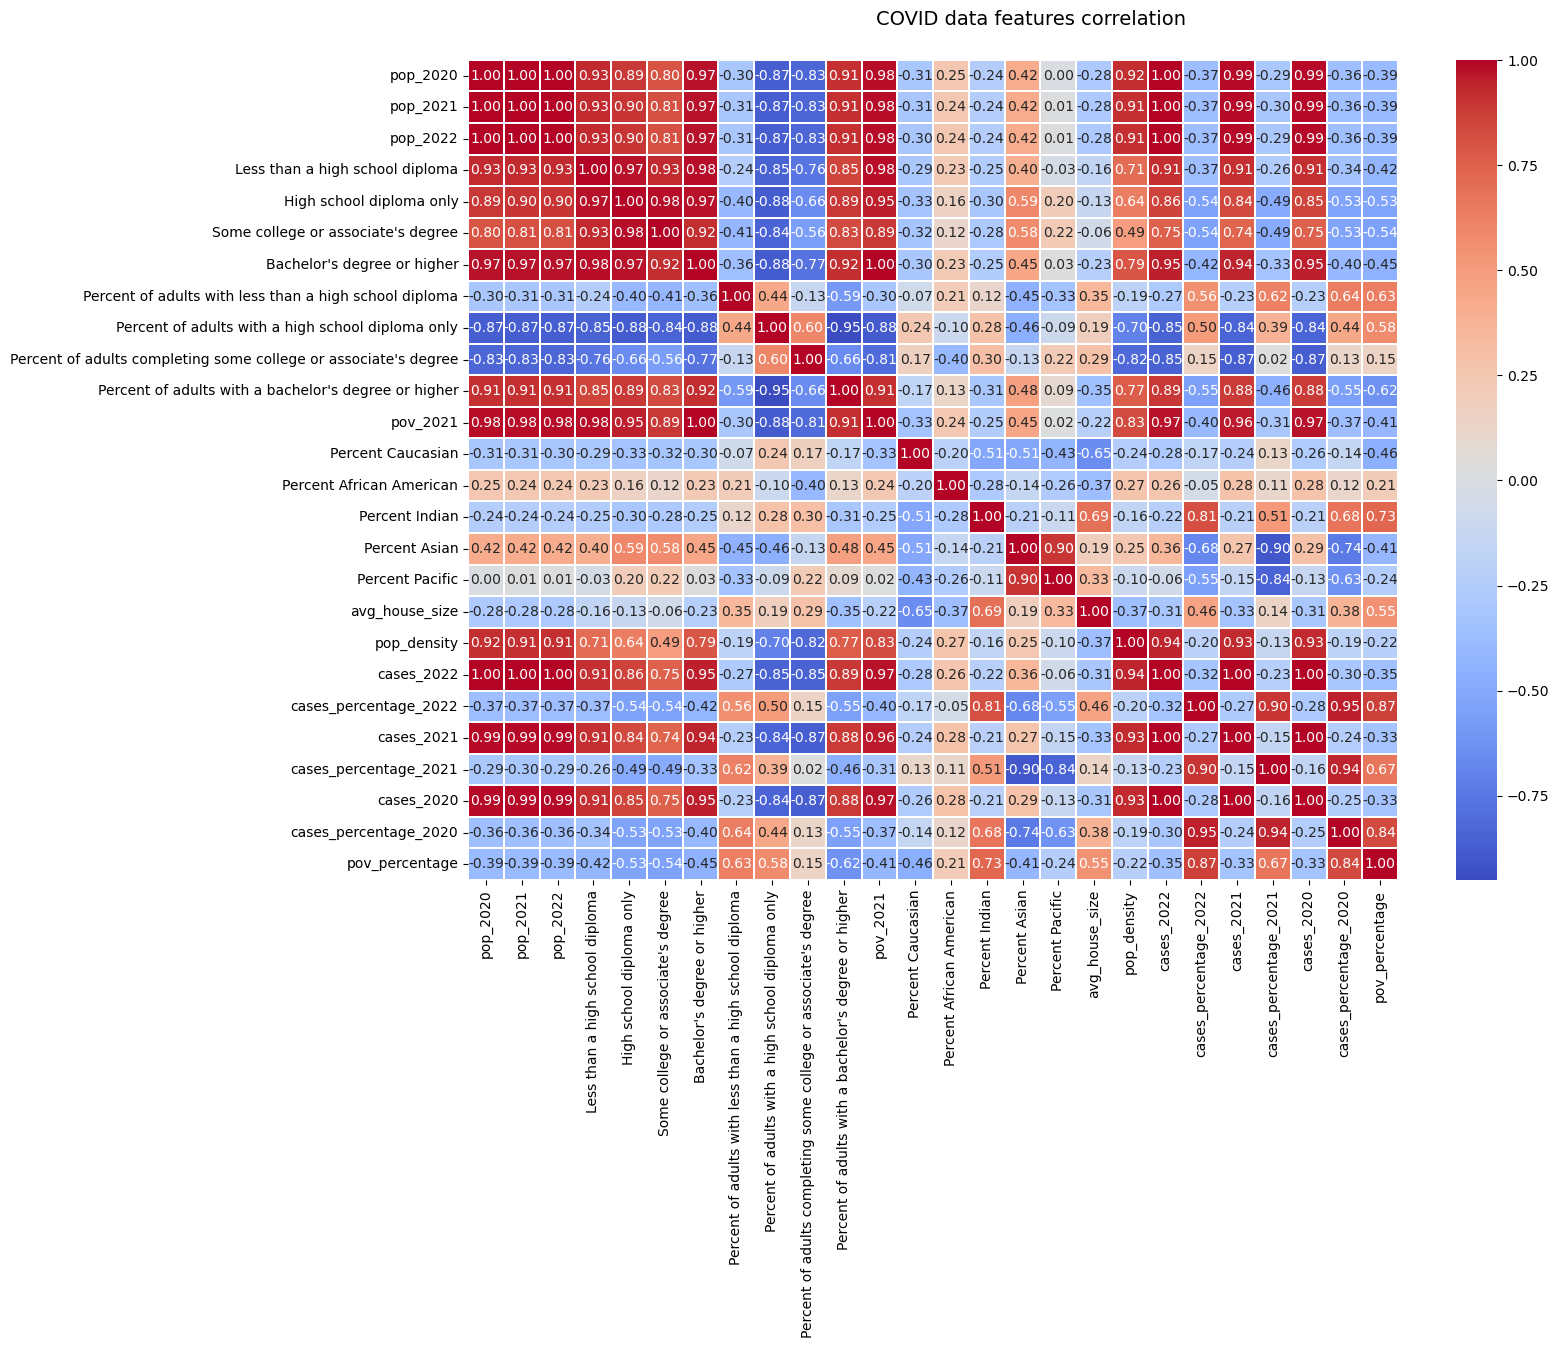

In [26]:
corrmat = df_demo_mean.corr()
f, ax = plt.subplots(figsize=(15, 10))
hm = sns.heatmap(round(corrmat,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('COVID data features correlation', fontsize=14)

There's now some interesting statistics that we can see based off the grouped clusters that are reasonable sizes as well.

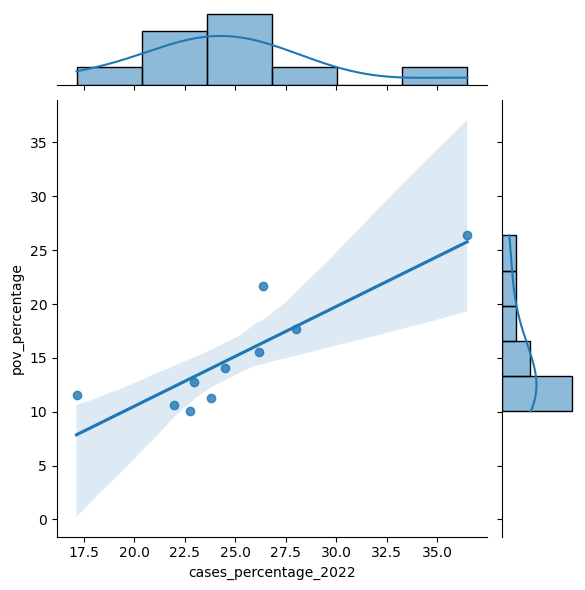

In [27]:
sns.jointplot(x='cases_percentage_2022', y='pov_percentage', data=df_demo_mean, kind="reg");

This graph shows with a .87 regression that the covid cases totaling in 2022 based off population were can be correlated with the poverty percentage of each county.

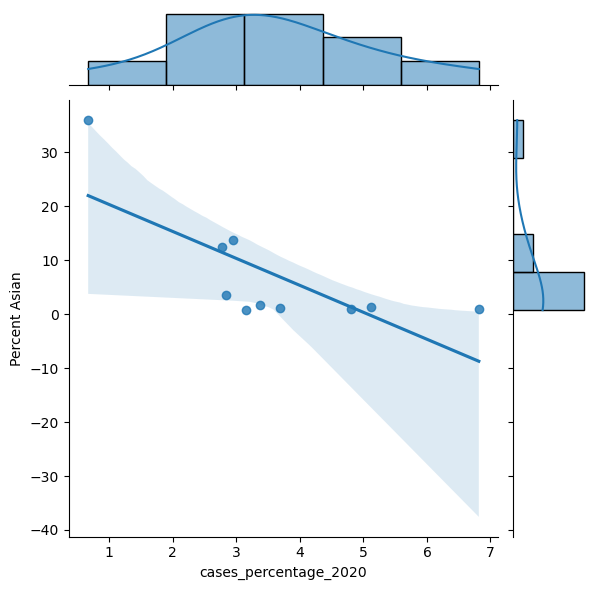

In [28]:
sns.jointplot(x='cases_percentage_2020', y='Percent Asian', data=df_demo_mean, kind="reg");

This graph shows that in the early stages of COVID-19 cases in 2020, that the Asian population was not heavily dominating the demographics. This may be influenced by the small Asian demographic percentage in the United States compared to Caucasians and African Americans.

We can try and formulate the data in reverse by looking at the covid case percentages.

In [29]:
df_scale.head()

Percent of adults with less than a high school diploma  \
0                                          -0.707456        
1                                          -1.323386        
2                                          -1.391822        
3                                          -1.665569        
4                                          -0.827220        

   Percent of adults with a high school diploma only  \
0                                          -0.597062   
1                                          -2.345078   
2                                          -1.691240   
3                                           0.723958   
4                                          -0.610406   

   Percent of adults completing some college or associate's degree  \
0                                           0.291196                 
1                                          -0.565506                 
2                                           0.215045                 
3                                           0.310234                 
4                                           0.443499                 

   Percent of adults with a bachelor's degree or higher  Percent Caucasian  \
0                                           0.714203             -2.420637   
1                                           2.852449              0.496776   
2                                           1.985047              0.532143   
3                                           0.260331             -0.046971   
4                                           0.724289             -2.331442   

   Percent African American  Percent Indian  Percent Asian  Percent Pacific  \
0                 -0.594599       -0.179770      11.510289        24.160078   
1                 -0.606565       -0.125038       0.216934         0.234754   
2                 -0.578355        0.062850       0.287493         0.441985   
3                 -0.625097        1.548160       0.070157         0.684231   
4                 -0.573710       -0.117159       9.194473        29.532111   

   avg_house_size  pop_density  cases_percentage_2022  cases_percentage_2021  \
0        2.241223    -0.116388              -1.306523              -3.187091   
1       -1.791815    -0.137732              -2.995211              -3.006598   
2       -1.498503    -0.218836              -2.689044              -2.927622   
3       -0.398584    -0.235587               0.952641              -2.890696   
4        1.177967    -0.185440              -1.944857              -2.856097   

   cases_percentage_2020  pov_percentage  Cluster  
0              -1.694429       -0.590967        2  
1              -1.626110       -0.638365        2  
2              -1.590165       -0.582749        2  
3              -1.372687       -0.633772        0  
4              -1.389798        0.058112        2

In [30]:
df_covid = df_scale[['cases_percentage_2020', 'cases_percentage_2021', 'cases_percentage_2022']]
df_covid.head()

cases_percentage_2020  cases_percentage_2021  cases_percentage_2022
0              -1.694429              -3.187091              -1.306523
1              -1.626110              -3.006598              -2.995211
2              -1.590165              -2.927622              -2.689044
3              -1.372687              -2.890696               0.952641
4              -1.389798              -2.856097              -1.944857

In [31]:
wccs = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_covid)
    wccs.append(kmeans.inertia_)

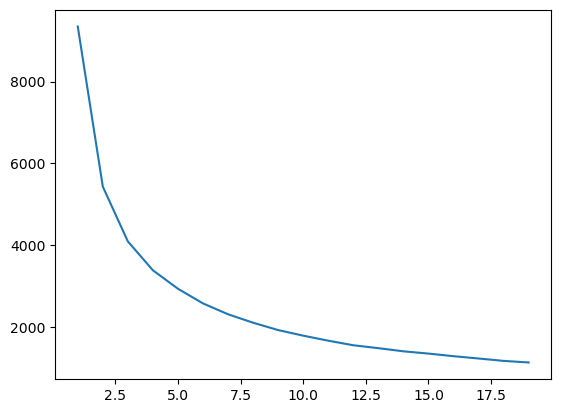

In [32]:
plt.plot(range(1, 20), wccs)

This graph shows that it might be best to use 7 clusters this time.

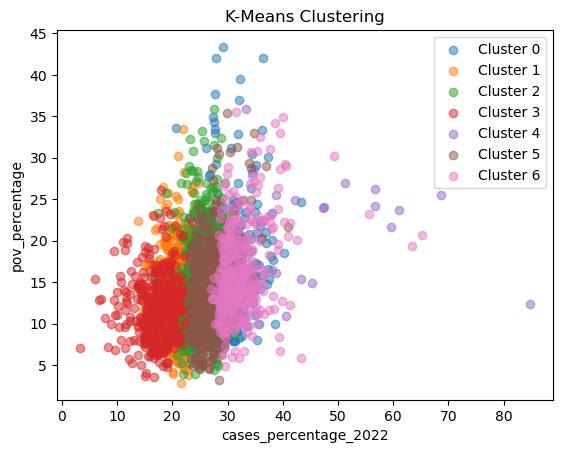

In [33]:
# Create a KMeans instance
kmeans = KMeans(n_clusters=7, random_state=42)

# Fit the model to your data
kmeans.fit(df_covid)

# Get cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to your DataFrame
df_covid['Cluster'] = labels

# plot df_scale using covid cases

df_covid = pd.concat([county_stats, df_covid['Cluster']], axis=1)

for cluster in range(7):
    cluster_data = df_covid[df_covid['Cluster'] == cluster]
    plt.scatter(cluster_data.iloc[:, 22], cluster_data.iloc[:, 27], label=f'Cluster {cluster}', alpha=0.5)

plt.title('K-Means Clustering')
plt.xlabel('cases_percentage_2022')
plt.ylabel('pov_percentage')
plt.legend()
plt.show()

We can already notice some differences between the covid case percentage from 2022 and poverty percentage before looking at a heatmap.

In [34]:
for label in range(7):
    print('Cluster ' + str(label) + ' has size ' + str(len(df_covid[df_covid['Cluster'] == label])))

Cluster 0 has size 226
Cluster 1 has size 733
Cluster 2 has size 674
Cluster 3 has size 400
Cluster 4 has size 24
Cluster 5 has size 706
Cluster 6 has size 352


In [35]:
df_covid_mean = df_covid.drop(columns=['state','county'], axis=1).groupby('Cluster').mean()
df_covid_mean

pop_2020       pop_2021       pop_2022  \
Cluster                                                
0         44155.849558   44180.269912   44248.398230   
1        125180.998636  125837.439291  126753.403820   
2         92871.317507   93087.013353   93475.278932   
3        106993.692500  107112.130000  107373.422500   
4        120948.541667  119820.500000  119878.541667   
5        122550.977337  122594.924929  123208.828612   
6         96745.872159   96149.991477   95918.559659   

         Less than a high school diploma  High school diploma only  \
Cluster                                                              
0                            4076.433628               8516.473451   
1                            8371.152797              22064.248295   
2                            7612.206231              17011.599407   
3                            6299.612500              16787.022500   
4                           14972.000000              23266.333333   
5                            7960.245042              21352.570822   
6                            9655.088068              17714.071023   

         Some college or associate's degree  Bachelor's degree or higher  \
Cluster                                                                    
0                               8621.535398                  7004.845133   
1                              24172.754434                 30737.637108   
2                              18285.026706                 18612.801187   
3                              21428.250000                 30428.115000   
4                              21075.541667                 26221.750000   
5                              22438.230878                 24684.531161   
6                              18431.687500                 20169.789773   

         Percent of adults with less than a high school diploma  \
Cluster                                                           
0                                                15.380973        
1                                                11.170123        
2                                                12.529080        
3                                                 9.212500        
4                                                16.350000        
5                                                11.460198        
6                                                14.807386        

         Percent of adults with a high school diploma only  \
Cluster                                                      
0                                                34.812389   
1                                                32.881446   
2                                                34.267804   
3                                                29.965750   
4                                                37.608333   
5                                                35.546742   
6                                                36.305398   

         Percent of adults completing some college or associate's degree  \
Cluster                                                                    
0                                                30.548230                 
1                                                31.042701                 
2                                                31.537389                 
3                                                31.778500                 
4                                                29.779167                 
5                                                30.675779                 
6                                                29.759375                 

         Percent of adults with a bachelor's degree or higher      pov_2021  \
Cluster                                                                       
0                                                19.253982      6733.986726   
1                                                24.904502     14842.686221   
2                            

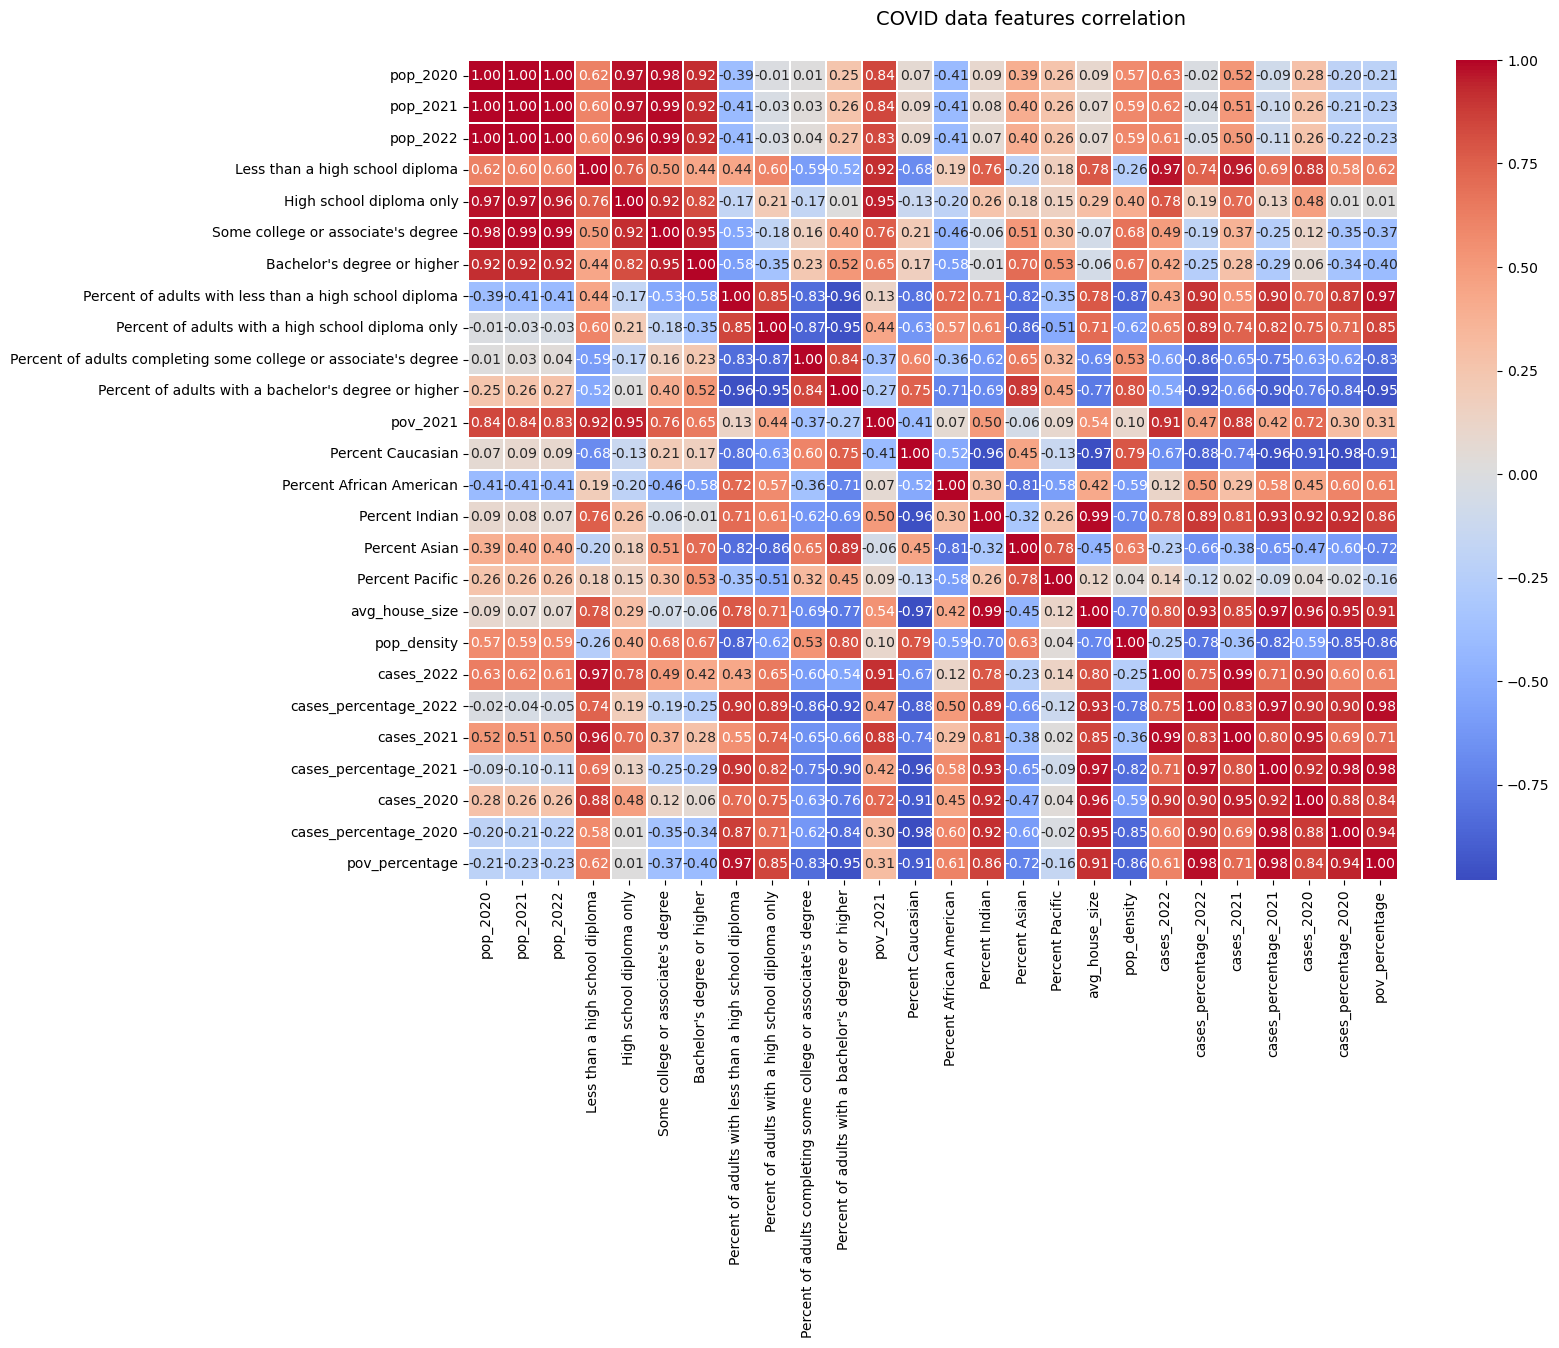

In [36]:
corrmat = df_covid_mean.corr()
f, ax = plt.subplots(figsize=(15, 10))
hm = sns.heatmap(round(corrmat,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('COVID data features correlation', fontsize=14)

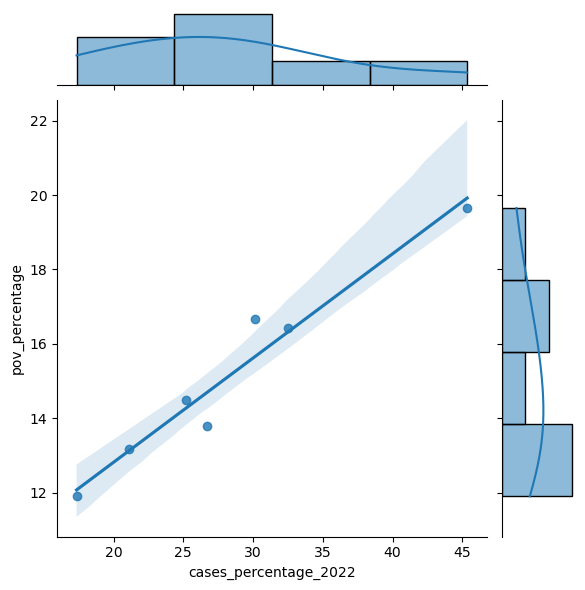

In [37]:
sns.jointplot(x='cases_percentage_2022', y='pov_percentage', data=df_covid_mean, kind="reg");

This graph shows a much higher correlation (.98) than our previous model.

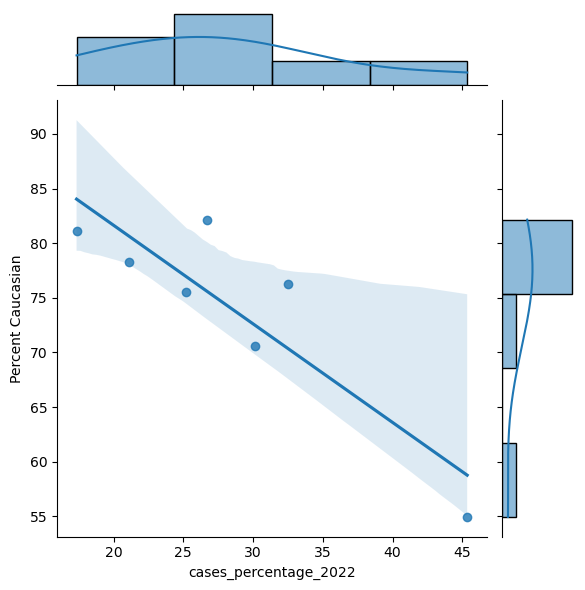

In [38]:
sns.jointplot(x='cases_percentage_2022', y='Percent Caucasian', data=df_covid_mean, kind="reg");

This graph shows a negative correlation between Caucasian and covid case percentages.

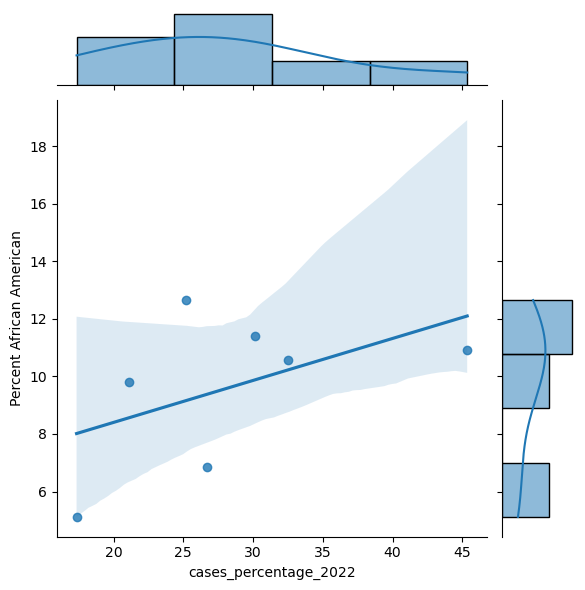

In [39]:
sns.jointplot(x='cases_percentage_2022', y='Percent African American', data=df_covid_mean, kind="reg");

This graph shows a moderate correlation between the African American and covid case percentages.

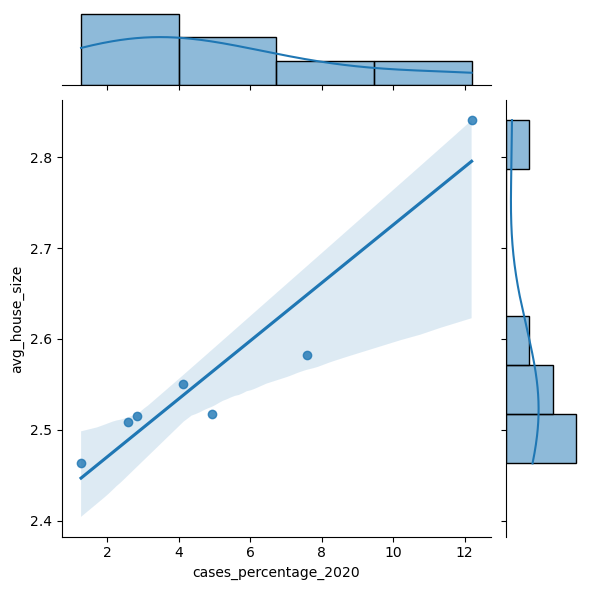

In [40]:
sns.jointplot(x='cases_percentage_2020', y='avg_house_size', data=df_covid_mean, kind="reg");

This last graph shows a strong correlation between 2020 COVID-19 cases and the average house size in the US.

## Conclusion

COVID-19 was an infection that affected most / if not all of the United States. Finding correlations between those counties that had higher rates of COVID-19 over the years is not easy because of how diverse the United States is. However, we were able to notice some slight trends when grouping counties by either there case percentage (from population) or by demographics and then looking at vice versa to see results. These models are not perfect, but do show how that some demographic features such as poverty, race, average house size, etc can play a factor in why a county might exhibit higher counts of COVID-19 than others. There are always outside factors such as those who choose to get a vaccine, events in the early days that may have been 'super spreaders', and others but, for the most part, we can definitely take this data / results and look at how we can prevent such contageous and infectious new diseases in the future.